<a href="https://colab.research.google.com/github/pbabvey/label_masking/blob/master/optimal_BERT_SEQ_TAG_SEMEVAL_MULTITASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#based on the new idea rather than sequential

In [0]:
!pip install transformers


In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForTokenClassification, AdamW, BertConfig



Using TensorFlow backend.


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [0]:
torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

In [0]:
torch.cuda.empty_cache()

In [0]:
data = pd.read_csv("train.csv", encoding="utf-8").fillna(method="ffill")
#data = data.loc[:100]
data.tail(10)




,sentenceID,sentence,antecedent,consequent,antecedent_startid,antecedent_endid,consequent_startid,consequent_endid
3541,203541,If the Labour leader's motion had been success...,If the Labour leader's motion had been successful,it could have led to May's departure as prime ...,0,48,51,133
3542,203542,"bu t the problem with that, is other people's ...",i just wish we could have all you idiot's abor...,{},67,133,-1,-1
3543,203543,"David Rees, emerging markets economist at Capi...",if not for not processing the payments,the payments could have enabled Argentina to r...,91,128,131,201
3544,203544,Had President Donald Trump studied the contrad...,Had President Donald Trump studied the contrad...,his ambition to make closer Saudi relations th...,0,79,82,203
3545,203545,"""In the past, I should have tried to talk him ...",I should have tried to talk him out of it,{},14,54,-1,-1
3546,203546,If there were peace I wouldn't spend another s...,If there were peace,I wouldn't spend another second here,0,18,20,55
3547,203547,Just wish I had someone besides Dr. Google to ...,Just wish I had someone besides Dr. Google to ...,{},0,87,-1,-1
3548,203548,"If he had greater inner peace, perhaps he coul...",If he had greater inner peace,perhaps he could generate peace instead of con...,0,28,31,106
3549,203549,I've been wondering for a while how to reply t...,had I sat down to write on another evening,I'd have written something rather different,76,117,119,161
3550,203550,As Fiorella De Fiore and Harald Uhlig show in ...,the Great Recession would have been worse if f...,As Fiorella De Fiore and Harald Uhlig show in ...,59,163,0,56


In [0]:
sentences = list(data.sentence.values)
#sentences_origin = sentences
#sentences = [sent for sent in sentences if len(sent)<100]
N = len(sentences)
print(max([len(x) for x in sentences]))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_sentences = [tokenizer.tokenize(sent) for sent in sentences]
labels = [{token:0 for token in tokenized_sentence} for tokenized_sentence in tokenized_sentences]

1485


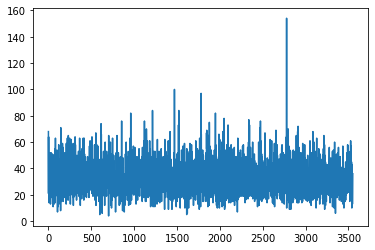

In [0]:
A = [len(x) for x in labels]
import matplotlib.pyplot as plt
plt.plot(range(len(A)),A)

In [0]:
for i in range(3000,3200):
    #print(i)
    #print(sentences[i])
    pass
    

In [0]:
print(len(labels))
M = max([len(x) for x in labels])
print(M)
M = sum([len(x) for x in labels])
print(M/len(labels))
print(len(sentences[1]))

3551
154
32.62630245001408
110


In [0]:
A = [len(x) for x in labels]
print(max(A))
import matplotlib.pyplot as plt


154


In [0]:
def slice(text, ant, con):
    #print(text, ant, con)
    n = len(text)
    if ant == -1:
        ant = (-1, -1)
    if con == -1:
        con = (-1, -1)
    
    temp = 0

    if ant[0] == 0:
        A = ant[1]
        return [(1,text[:A+1])] +slice(text[A+1:], -1, (con[0]-A-1, con[1]-A-1))

    elif con[0] == 0:
        B = con[1]
        return [(2,text[:B+1])] +slice(text[B+1:], (ant[0]-B-1,ant[1]-B-1), -1 )

    elif ant[0] > 0 or  con[0] > 0:
        if ant[0] < 0:
            C = con[0]
        elif con[0] < 0:
            C = ant[0]
        else:
            C = min(ant[0], con[0])
        return [(0,text[:C])] + slice(text[C:], (ant[0]-C,ant[1]-C), (con[0]-C, con[1]-C))
    elif len(text) > 0:
        return [(0,text)]
    else:
        return []

# an example of how it works
sent = 'Have a nice weekend my friend!'
S = slice(sent, (0,5), (7,18))
print(S)
label = []
for s in S:
    
    tokens = tokenizer.tokenize(s[1])
    label.extend([s[0] for token in tokens])
label = [0] + label + [0]
print(label)

print(tokenizer.tokenize(sent))

[(1, 'Have a'), (0, ' '), (2, 'nice weekend'), (0, ' my friend!')]
[0, 1, 1, 2, 2, 0, 0, 0, 0]
['have', 'a', 'nice', 'weekend', 'my', 'friend', '!']


In [0]:

antecedents_loc = list(zip(data.antecedent_startid.values,data.antecedent_endid.values))
consequents_loc = list(zip(data.consequent_startid.values,data.consequent_endid.values))

#antecedents_loc = [x for i,x in enumerate(antecedents_loc) if len(sentences_origin[i])<200]
#consequents_loc = [x for i,x in enumerate(consequents_loc) if len(sentences_origin[i])<200]

#sentences = [sent for sent in sentences if len(sent)<200]
pre_labels = []
for i in range(N):
    S = slice(sentences[i], antecedents_loc[i], consequents_loc[i])
    #print(S)
    label = []
    for s in S:
        tokens = tokenizer.tokenize(s[1])
        label.extend([s[0] for token in tokens])
    label = [0] + label + [0]
    pre_labels.append(label)



In [0]:
#longest on is in index ~2900

In [0]:
max_length = 320
pad_token=0
input_ids = []
attention_masks = []
token_type_ids = []
labels = [[] for i in range(len(pre_labels))]
for i,sentence in enumerate(sentences):
    inputs = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        max_length = max_length,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                )
    input_id, token_type_id = inputs["input_ids"], inputs["token_type_ids"]

    attention_mask = [1] * len(input_id)

    # Zero-pad up to the sequence length.
    padding_length = max_length - len(input_id)
    if i in [126]:
        pre_labels[i] = pre_labels[i][:-1]
    if i in [2490]:
        pre_labels[i] = pre_labels[i][:-3]

    if len(pre_labels[i]) != len(input_id):
        print(i)
        print(len(pre_labels[i]), len(input_id))
        print(input_id)
        print(len(sentences[i]))
        print(sentences[i])
        print(antecedents_loc[i])
        print(consequents_loc[i])
    label = pre_labels[i]
    #label2 = label[:len(input_id)]

    input_id = input_id + ([pad_token] * padding_length)
    attention_mask = attention_mask + ([0] * padding_length)
    token_type_id = token_type_id + ([0] * padding_length)

    labels[i] = label + ([3] * (padding_length))
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)      

In [0]:
#batch size is 4 to counteract the cuda memory error
bs = 8

In [0]:
print(len(input_ids))
print(len(labels))
print(len(token_type_ids))
print(len(attention_masks))
print(set([x for label in labels for x in label]))

for i in range(len(labels)):
    if len(labels[i]) != max_length:
        print(i)
        print(len(labels[i]))

3551
3551
3551
3551
{0, 1, 2, 3}


In [0]:
'''
n = 0
k = 2500
input_ids = input_ids[n:n+k]
labels = labels[n:n+k]
attention_masks = attention_masks[n:n+k]
token_type_ids = token_type_ids[n:n+k]
'''

"""
f_input_ids = []
f_labels = []
f_attention_masks = []
f_token_type_ids = []
for i,l in enumerate(labels):
    if sum(attention_masks[i]) < 20:  
        f_input_ids.append(input_ids[i])
        f_labels.append(labels[i])
        f_attention_masks.append(attention_masks[i])
        f_token_type_ids.append(token_type_ids[i])

input_ids = f_input_ids
labels = f_labels
token_type_ids = f_token_type_ids
attention_masks = f_attention_masks
print(len(labels))
"""

'\nf_input_ids = []\nf_labels = []\nf_attention_masks = []\nf_token_type_ids = []\nfor i,l in enumerate(labels):\n    if sum(attention_masks[i]) < 20:  \n        f_input_ids.append(input_ids[i])\n        f_labels.append(labels[i])\n        f_attention_masks.append(attention_masks[i])\n        f_token_type_ids.append(token_type_ids[i])\n\ninput_ids = f_input_ids\nlabels = f_labels\ntoken_type_ids = f_token_type_ids\nattention_masks = f_attention_masks\nprint(len(labels))\n'

In [0]:
tr_inputs, val_inputs, tr_tags, val_tags= train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, tr_types, val_types = train_test_split(attention_masks, token_type_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
'''
t_input_ids = []
t_labels = []
t_attention_masks = []
t_token_type_ids = []
for i,l in enumerate(labels):
    if 30< sum(attention_masks[i]) < 50:  
        t_input_ids.append(input_ids[i])
        t_labels.append(labels[i])
        t_attention_masks.append(attention_masks[i])
        t_token_type_ids.append(token_type_ids[i])

print(len(t_labels))

v_input_ids = []
v_labels = []
v_attention_masks = []
v_token_type_ids = []
for i,l in enumerate(labels):
    if sum(attention_masks[i]) < 30 :  
        v_input_ids.append(input_ids[i])
        v_labels.append(labels[i])
        v_attention_masks.append(attention_masks[i])
        v_token_type_ids.append(token_type_ids[i])

input_ids = v_input_ids
labels = v_labels
token_type_ids = v_token_type_ids
attention_masks = v_attention_masks

print(len(v_labels))

tr_inputs, val_inputs, tr_tags, val_tags= train_test_split(t_input_ids, t_labels,
                                                        random_state=2018, test_size=0.01)
tr_masks, val_masks, tr_types, val_types = train_test_split(t_attention_masks, t_token_type_ids,
                                             random_state=2018, test_size=0.01)

_, val_inputs, _, val_tags= train_test_split(v_input_ids, v_labels,
                                                        random_state=2018, test_size=0.2)
_, val_masks, _, val_types = train_test_split(v_attention_masks, v_token_type_ids,
                                             random_state=2018, test_size=0.2)

'''

'\nt_input_ids = []\nt_labels = []\nt_attention_masks = []\nt_token_type_ids = []\nfor i,l in enumerate(labels):\n    if 30< sum(attention_masks[i]) < 50:  \n        t_input_ids.append(input_ids[i])\n        t_labels.append(labels[i])\n        t_attention_masks.append(attention_masks[i])\n        t_token_type_ids.append(token_type_ids[i])\n\nprint(len(t_labels))\n\nv_input_ids = []\nv_labels = []\nv_attention_masks = []\nv_token_type_ids = []\nfor i,l in enumerate(labels):\n    if sum(attention_masks[i]) < 30 :  \n        v_input_ids.append(input_ids[i])\n        v_labels.append(labels[i])\n        v_attention_masks.append(attention_masks[i])\n        v_token_type_ids.append(token_type_ids[i])\n\ninput_ids = v_input_ids\nlabels = v_labels\ntoken_type_ids = v_token_type_ids\nattention_masks = v_attention_masks\n\nprint(len(v_labels))\n\ntr_inputs, val_inputs, tr_tags, val_tags= train_test_split(t_input_ids, t_labels,\n                                                        random_state=

In [0]:
for i, t in enumerate(tr_tags):
    if len(t) != max_length:
        print(i)
        print(len(t))
print('---')


---


In [0]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

tr_types = torch.tensor(tr_types)
val_types = torch.tensor(val_types)

In [0]:
print(len(tr_inputs))
print(val_tags)
print(val_masks)
print(val_types)

3195
tensor([[0, 0, 0,  ..., 3, 3, 3],
        [0, 1, 1,  ..., 3, 3, 3],
        [0, 0, 2,  ..., 3, 3, 3],
        ...,
        [0, 0, 1,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3],
        [0, 2, 2,  ..., 3, 3, 3]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [0]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_types, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_types, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [0]:
import numpy as np
import torch
out_arr = np.random.randint(low = 0, high = 2, size = 5) 
torch.from_numpy(out_arr).bool()

tensor([ True,  True,  True, False, False])

In [0]:
import numpy as np
def threshold(level,k,N):
    out = level*(1-np.exp(-(N-k)/N))
    out = level *(1-k/N)
    return out
threshold(8,30,64)

4.25

In [0]:
import numpy as np
r = np.random.choice(2, 12, p=[0.5, 0.5]) 
r

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [0]:
nparr = np.zeros((12,12))
r = np.random.choice(2, 12, p=[0.0001, 0.9999]) 
ones = [i for i,a in enumerate(r) if a==1]
nparr[:,ones] = 1 
nparr[:,0] = 0
nparr[:,-1] = 0
A = torch.Tensor(nparr)
end=5
nparr = np.zeros((12,12), dtype=int)
r = np.random.choice(2, end, p=[0.1, 0.9]) 
r[0] = r[-1]= 0
r = np.concatenate((r, np.zeros(12-end)), axis=-1) 
ones = [i for i,a in enumerate(r) if a==1]
zeros = [i for i,a in enumerate(r) if a==0]
nparr[:,ones] = 1 
nparr[:,0] = 0
nparr[:,-1] = 0
nparr = nparr.astype('int')
np_mask = torch.Tensor(nparr).to(device)
np_mask[np_mask==1] = float("-Inf")
print(np_mask)

tensor([[0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')


In [0]:
import torch
A = torch.Tensor([[[1,2],[3,4]],[[5,6],[7,8]],[[5,5],[-3,8]]])
print(A,'\n')
#A = torch.Tensor([[[1,2],[3,4],[5,6]]])
A.repeat(1,2,1)
A[:2,:,:] = torch.Tensor([[1,1],[-3,4]])
A

tensor([[[ 1.,  2.],
         [ 3.,  4.]],

        [[ 5.,  6.],
         [ 7.,  8.]],

        [[ 5.,  5.],
         [-3.,  8.]]]) 



tensor([[[ 1.,  1.],
         [-3.,  4.]],

        [[ 1.,  1.],
         [-3.,  4.]],

        [[ 5.,  5.],
         [-3.,  8.]]])

In [0]:
import random
NPARR = np.zeros((4*3,5,5))
for b in range(4):
    S = 3

    nparr = np.zeros((5,5), dtype=int)
    k = random.randint(0, S) 
    L = [0]*k+[1]*(S-k)
    random.shuffle(L)
    r = np.array([0] + L) 
    r = np.concatenate((r, np.zeros(5-S-1)), axis=-1) 
    ones = [i for i,a in enumerate(r) if a==1]
    #print(len(ones))
    temp = [x+5*b for x in ones]
    zeros = [i for i,a in enumerate(r) if a==0]
    nparr[:,ones] = 1 
    #nparr[:,0] = 0
    nparr[:,S+1:] = 1
    nparr = nparr.astype('int')
    NPARR[b*3:(b+1)*3,:,:] = nparr
NPARR    

array([[[0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]],

       [[0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]],

       [[0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]],

       [[0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.]],

       [[0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.]],

       [[0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.]],

       [[0., 1., 0., 1., 1.],
        [0., 1., 0., 1., 1.],
        [0., 1., 0., 1., 1.]

In [0]:
for i in range(10):
    k = random.randint(0, S) 
    print(k)
    L = [0]*k+[1]*(S-k)
    print(L)
    random.shuffle(L)
    print(L)

0
[1, 1, 1]
[1, 1, 1]
0
[1, 1, 1]
[1, 1, 1]
1
[0, 1, 1]
[1, 0, 1]
3
[0, 0, 0]
[0, 0, 0]
0
[1, 1, 1]
[1, 1, 1]
1
[0, 1, 1]
[1, 0, 1]
3
[0, 0, 0]
[0, 0, 0]
3
[0, 0, 0]
[0, 0, 0]
0
[1, 1, 1]
[1, 1, 1]
3
[0, 0, 0]
[0, 0, 0]


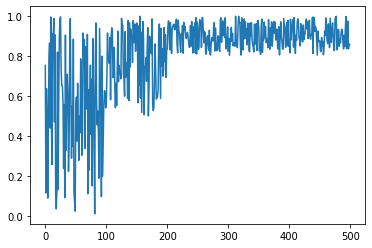

In [0]:
import random
import matplotlib.pyplot as plt
import numpy as np
# 1 means you reveal nothing
'''
def Prob(N):
    x = 0
    p = 1
    while x<N:
        yield p
        x += 1
    while x < 2*N:
        x += 1
        yield 0.9+random.random()/10
    while x < 3*N:
        x += 1
        yield 0.8+random.random()/5
    while x < 4*N:
        x += 1
        yield 0.6+random.random()/2.5
    while True:
        x += 1
        yield 0.5+random.random()/2
'''
# p means p% of labels are hidden
def Prob(N):
    x = 0
    while x<N:
        yield random.random()
        x += 1
    while x < 2*N:
        x += 1
        yield random.random()/2+0.5
    while True:
        x += 1
        yield random.random()/5+0.8


A = []
P = Prob(100)
for i in range(500):
    A.append(next(P))
plt.plot(range(500),A)

In [0]:
import numpy as np
A = np.array([1,2,3,4,5,6])
B = np.array([-1,-2,-3,-4,-5,-6])
h = [2,4]
A[h]=B[[1,3]]
A

array([ 1,  2, -2,  4, -4,  6])

In [0]:
import math
import numpy as np
import torch.nn as nn
from transformers import BertModel, BertConfig
from torch.autograd import Variable
import random
class LabelEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model=768, dropout=0.1, max_len=500):
        super(LabelEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        self.max_len = max_len
        
    def forward(self, x, labels):

        l = labels.shape[-1]
        b = labels.shape[0]
        #labels.extend([3]*(self.max_len-len(labels)))
        #labels = labels.unsqueeze(-1)
        #print(labels)
        c_labels = torch.zeros(b,self.max_len)
        c_labels[:,:]=3
        c_labels[:,:l] = labels
        c_labels = c_labels.unsqueeze(-1)
        c_labels = c_labels.to(device)
        pe = torch.zeros(b,self.max_len, self.d_model).to(device)
        div_term = torch.exp(torch.arange(0, self.d_model, 2) *
                             -(math.log(7000.0) / self.d_model)).to(device)
        for bb in range(b):
            pe[bb,:, 0::2] = torch.sin(c_labels[bb] * div_term)
            pe[bb,:, 1::2] = torch.cos(c_labels[bb] * div_term)
        #pe = pe.unsqueeze(0)

        #print(pe)
        x = x + Variable(pe[:,:x.size(1),:], 
                         requires_grad=False)
        return self.dropout(x)
'''
L = LabelEncoding(8,0,20)
A = torch.zeros(2,6,8)
labels = torch.tensor([[1,2,1,0,2,1],[0,0,0,0,0,1]])
B = L(A,labels)
B.detach().cpu()
'''

'\nL = LabelEncoding(8,0,20)\nA = torch.zeros(2,6,8)\nlabels = torch.tensor([[1,2,1,0,2,1],[0,0,0,0,0,1]])\nB = L(A,labels)\nB.detach().cpu()\n'

In [0]:
N = nn.Embedding(5, 3,max_norm=1)
A = torch.tensor([0,0,1,2])
B = N(A)
print(B)
print(torch.eye(3))

tensor([[-0.4430,  0.6993,  0.5610],
        [-0.4430,  0.6993,  0.5610],
        [-0.5627,  0.6249, -0.5044],
        [-0.6018, -0.6039, -0.5226]], grad_fn=<EmbeddingBackward>)
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [0]:
import math
import numpy as np
import torch.nn as nn
from transformers import BertModel, BertConfig
from torch.autograd import Variable
import random
num_tags = 3

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model=768, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)


class BertForMultiTaskTokenClassification(nn.Module):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.
    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].
    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].
    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
    num_labels = 2
    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, num_classes=[3]):
        #self.half_dim = 384
        super(BertForMultiTaskTokenClassification, self).__init__()
        self.num_classes = num_classes
        self.heads = 12
        self.prob = Prob(1500) #2500
        self.att_dim = 768
        #self.att_heads = 8
        #self.w0 = Variable(torch.Tensor(1), requires_grad=True).to(device)
        #self.w1 = Variable(torch.Tensor(1), requires_grad=True).to(device)
        #self.w2 = Variable(torch.Tensor(1), requires_grad=True).to(device)
        
        # https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertModel
        # output: sequence_output, pooled_output, (hidden_states), (attentions)
        config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        self.bert = BertModel.from_pretrained(
            "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
            output_attentions = False, # Whether the model returns attentions weights.
            output_hidden_states=True)
            #output_hidden_states = False, # Whether the model returns all hidden-states.
            #config=config

        self.config = self.bert.config
        self.dropout = torch.nn.Dropout(p=0.1)
        self.dropout2 = torch.nn.Dropout(p=0.1)
        self.classifier0 = torch.nn.Linear(self.config.hidden_size, self.num_classes[0]) # encoder to targets config.hidden_size
        self.classifier1 = torch.nn.Linear(self.config.hidden_size, self.num_classes[0]) # encoder to targets config.hidden_size
        #self.classifier1 = torch.nn.Linear(self.num_classes[0], config.hidden_size)
        #self.classifier2 = torch.nn.Linear(self.config.hidden_size, self.num_classes[1])
        #self.apply(self.init_bert_weights)
        self.target_embedding = nn.Embedding(5, self.att_dim,max_norm=1) #0,1,2,3, 4 for start
        self.pe = PositionalEncoding(self.att_dim, 0.1)
        self.le = LabelEncoding(self.att_dim, 0.1)
        self.mlthead_attn_0 = nn.MultiheadAttention( self.att_dim, self.heads, dropout=0.1)
        self.mlthead_attn_1 = nn.MultiheadAttention( self.att_dim, self.heads, dropout=0.1)
        self.mlthead_attn_2 = nn.MultiheadAttention( self.att_dim, self.heads, dropout=0.1)
        self.mlthead_attn_3 = nn.MultiheadAttention( self.att_dim, self.heads, dropout=0.1)

        self.mlhead_target_classifier = torch.nn.Linear(2*self.att_dim, self.num_classes[0])
        self.merge_layers = torch.nn.Linear(self.config.hidden_size*8, self.att_dim)
        self.merge_att_layers = torch.nn.Linear(self.config.hidden_size*8, self.att_dim)
        #self.aux_classifier = torch.nn.Linear(self.config.hidden_size*2, self.config.hidden_size)
        #self.compare = torch.nn.Linear(self.config.hidden_size, 3)
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None, spacy_labels=None):
        sequence_output, _, hidden_states = self.bert(input_ids, token_type_ids, attention_mask)
        #print(len(hidden_states))  # 13
        #embedding_output = hidden_states[0]
        attention_hidden_states = hidden_states[5:] # 1: excludes first embedding layer
        attention_hidden_states = torch.stack(attention_hidden_states)
        attention_hidden_states = attention_hidden_states.permute(1, 2, 0, 3)
        attention_hidden_states = attention_hidden_states.contiguous().view(input_ids.shape[0], max_length, -1)
        bert_syrup = self.merge_layers(attention_hidden_states)
        bert_att_syrup = self.merge_att_layers(attention_hidden_states)
        #token_output = self.dropout(sequence_output)
        token_output = self.dropout(bert_syrup)
        token_output_att = self.dropout(bert_att_syrup)
        token_transposed = torch.transpose(token_output, 0, 1)
        token_transposed_att = torch.transpose(token_output_att, 0, 1)
        ONES= []
        if labels != None:
            # False key_padding_mask means zero.
            S_list = []
            NPARR = np.zeros((labels.shape[0]*self.heads,max_length,max_length))
            
            fillin = np.zeros((labels.shape[0],max_length), dtype=int)
            for b in range(labels.shape[0]):
                seq = (attention_mask[b]==1).nonzero()
                S = int(seq[-1,0].detach().cpu())
                S_list.append(S)

                nparr = np.zeros((max_length,max_length), dtype=int)
                '''
                k = random.randint(0, S) 
                L = [0]*k+[1]*(S-k)
                random.shuffle(L)
                '''
                # [p0,1-p0] lower p0 generate more 1 and more token to be predicted
                p = next(self.prob)
                L = np.random.choice(2, S+1, p=[1-p, p]) 
                
                #r = np.array([0] + L) 
                r = L
                r = np.concatenate((r, np.zeros(max_length-S-1)), axis=-1) 
                ones = [i for i,a in enumerate(r) if a==1]
                l = len(ones)
                #print(len(ones))
                temp = [x+max_length*b for x in ones]
                ONES.extend(temp)
                zeros = [i for i,a in enumerate(r) if a==0]
                nparr[:,ones] = 1 
                #nparr[:,0] = 0
                nparr[:,S+1:] = 1 #this is really critical and I think maybe giving this 3s in input changes evering
                nparr = nparr.astype('int')
                NPARR[b*self.heads:(b+1)*self.heads,:,:] = nparr
                fillin[b,:] = nparr[0]
            #print(NPARR)
            np_mask_extend = torch.Tensor(NPARR).to(device)
            fillin = torch.Tensor(fillin).to(device)
            psudo_labels = labels.clone()
            psudo_labels[fillin==1] = 3  
            #print(labels)
            #print(psudo_labels)
            #np_mask_extend = np_mask_extend.repeat(self.heads, 1, 1)
            np_mask_extend[np_mask_extend ==1] = float("-Inf")
            #print(np_mask_extend.shape)
            #print(np_mask_extend)

            #random_mask = torch.from_numpy(arr).bool().to(device)
            #t = (torch.ones(labels.shape[0],1)*4).to(device).long()
            #tamper_labels = torch.cat((t[:,0:],labels[:,1:]),-1)
            #print(psudo_labels)
            query_embed = self.target_embedding(psudo_labels)
            query_embed_2 = torch.transpose(query_embed, 0, 1)
            query_embed_pe = self.pe(query_embed)
            #print(query_embed_pe.shape)
            #token_output_le = self.pe(self.le(token_output,psudo_labels))
            #print(token_output_le.shape)
            #token_transposed_le = torch.transpose(token_output_le, 0, 1)
            #print(token_transposed_le.shape)
            #query_embed_pe[:,ones,:] = 0
            #query_embed_cat = torch.cat((query_embed_pe,aux),-1)
            query_embed_pe_2 = torch.transpose(query_embed_pe, 0, 1)
            query_embed_pe_2_plus = token_transposed + query_embed_pe_2 
            #token_output = torch.transpose(token_output, 0, 1)
            #print(query_embed_pe.shape)
            #print(query_embed_pe)
            #print(attention_mask)
            
            #print(np_mask)
            #np_mask =  Variable(torch.from_numpy(np_mask) == 0).to(device)
            #print(np_mask.shape)
            #print(torch.unsqueeze(attention_mask,-2).shape)
            #trg_mask = torch.unsqueeze(attention_mask,-2) & np_mask
            #print(trg_mask.shape)
            attn_output_0, attn_output_weights_0 = self.mlthead_attn_0(token_transposed_att, token_transposed_att, 
                                                                       query_embed_2) # , query, key, value
            #attn_output_0 += token_transposed

            attn_output_1, attn_output_weights_1 = self.mlthead_attn_1(attn_output_0, attn_output_0, attn_output_0
                                                                       ) #, attn_mask=np_mask
            attn_output_1 += attn_output_0
            '''
            attn_output_2, attn_output_weights_2 = self.mlthead_attn_2(attn_output_1, query_embed_pe_2, query_embed_pe_2
                                                                       , attn_mask= np_mask_extend) 
            attn_output_2 += attn_output_1

            attn_output_3, attn_output_weights_3 = self.mlthead_attn_3(attn_output_2, query_embed_pe_2, query_embed_pe_2
                                                                       , attn_mask= np_mask_extend) 
            attn_output_3 += attn_output_2
            '''
            attn_output_0 = torch.transpose(attn_output_0, 0, 1)
            #attn_output_3 = torch.transpose(attn_output_3, 0, 1)
            
            attn_output_0_drop = self.dropout2(attn_output_0)
            #attn_output_3_drop = self.dropout2(attn_output_3)
            '''
            catcat = torch.cat((attn_output_3_drop, token_output),-1)
            aux = self.aux_classifier(catcat)
            mlhead_targets = self.mlhead_target_classifier(aux)
            '''
            catcat = torch.cat((token_output, attn_output_0_drop),-1)
            mlhead_targets = self.mlhead_target_classifier(catcat)
            #mlhead_targets = self.mlhead_target_classifier(attn_output_3_drop)


            #targets1 = self.classifier0(pooled_output_drop)
            #targets2 = self.classifier1(pooled_output_drop)

            #targets1_transpose = torch.transpose(targets1, 0, 1)
            #labels_transpose = torch.transpose(labels, 0, 1)

            loss_fct = nn.CrossEntropyLoss(reduction='none',ignore_index=3) #
            loss_main = loss_fct(mlhead_targets.view(-1, 3), labels.flatten())    # stance
            '''
            to get just the hidden labels
            '''

            loss_sum = torch.sum(loss_main[ONES])
            if l>0:
                loss_sum = loss_sum/l
            '''
            to get all the inputs
            '''
            #loss_sum = torch.sum(loss_main)

            #loss_t = loss.item()
            return loss_sum, loss_sum, loss_sum

        else:
            B = input_ids.shape[0]
            S = input_ids.shape[1]
            
            output = []
            output_logits = []
            for b in range(B):
                seq = (attention_mask[b]==1).nonzero()
                S = int(seq[-1,0].detach().cpu().numpy())
                output.append([0]*(S+1)) # *(max_length - S-1)+[3]*(max_length - S) it may be a source of error if masking doesn't work properly
                #finalize = [0,S+1]  #list(range(S+1,max_length))
                finalize = []
                psudo_labels = np.zeros(S+1)
                psudo_labels[psudo_labels==0]=3
                for s in range(1,S+1):  # the steps can be reduced
                    o = np.array(output[-1])
                    psudo_labels[finalize]=o[finalize]
                    #psudo_labels_torch = torch.Tensor(psudo_labels).to(device).long()
                    if len(finalize) == S+1:
                        break
                    #nparr = np.ones((S+1,S+1))
                    '''
                    nparr = np.ones((S+1,S+1))
                    nparr[:,finalize] = 0 
                    np_mask = torch.Tensor(nparr).to(device)
                    np_mask[np_mask==1] = float("-Inf")
                    '''
                    np_mask = torch.eye(S+1).to(device)
                    np_mask[np_mask==1] = float("-Inf")
                    #thr_mask = torch.Tensor([[ i in finalize for i in range(S+2)]]).bool().to(device)
                    #print(output)
                    A = [x for x in psudo_labels]
                    query_embed = self.target_embedding(torch.Tensor([A]).to(device).long())
                    query_embed_2 = torch.transpose(query_embed, 0, 1)
                    #print(psudo_labels)
                    #query_embed = self.target_embedding(psudo_labels_torch)
                    #print(psudo_lables_torch)
                    ones = [o for o in range(max_length) if o not in finalize]
                    query_embed_pe = self.pe(query_embed)
                    
                    #query_embed_pe[:,ones,:] = 0
                    #query_embed_cat = torch.cat((query_embed_pe,torch.unsqueeze(aux[b,:S+2,:],0)),-1)
                    #token_output_le = self.pe(self.le(token_output[b,:S+2,:].unsqueeze(0),torch.tensor(psudo_labels).unsqueeze(0)))
                    #token_le_b_transposed = torch.transpose(token_output_le, 0, 1)
                    #print(token_le_b_transposed.shape)
                    query_embed_pe_2 = torch.transpose(query_embed_pe, 0, 1)
                    token_b_transposed = torch.transpose(token_output[b,:S+1,:].unsqueeze(0), 0, 1)
                    #token_output = token_output[b,:S+2,:].unsqueeze(0)
                    token_b_transposed_att = torch.transpose(token_output_att[b,:S+1,:].unsqueeze(0), 0, 1)
                    query_embed_pe_2_plus = token_b_transposed + query_embed_pe_2
                    attn_output_0, attn_output_weights_0 = self.mlthead_attn_0(token_b_transposed_att, token_b_transposed_att
                                                                               , query_embed_2, attn_mask=np_mask) 
                    #attn_output_0 += token_b_transposed

                    attn_output_1, attn_output_weights_1 = self.mlthead_attn_1(attn_output_0, attn_output_0, attn_output_0
                                                                            ) #, attn_mask=np_mask
                    attn_output_1 += attn_output_0
                    '''
                    attn_output_2, attn_output_weights_2 = self.mlthead_attn_2(attn_output_1, query_embed_pe_2, query_embed_pe_2
                                                                            , attn_mask= np_mask) 
                    attn_output_2 += attn_output_1

                    attn_output_3, attn_output_weights_3 = self.mlthead_attn_3(attn_output_2, query_embed_pe_2, query_embed_pe_2
                                                                            , attn_mask= np_mask) 
                    attn_output_3 += attn_output_2
                    '''
                    #attn_output_3 = torch.transpose(attn_output_3, 0, 1)
                    attn_output_0 = torch.transpose(attn_output_0, 0, 1)
                    
                    #print('shape',attn_output_3.shape)

                    #attn_output_3_drop = self.dropout2(attn_output_3)
                    attn_output_0_drop = self.dropout2(attn_output_0)

                    #print('token: ', token_output[b].unsqueeze(0).shape)
                    #print('drop :', attn_output_3_drop.shape)
                    '''
                    catcat_val = torch.cat((attn_output_3_drop, token_output[b,:S+2,:].unsqueeze(0)),-1)
                    aux = self.aux_classifier(catcat_val)
                    out = self.mlhead_target_classifier(aux)
                    '''
                    catcat_val = torch.cat((token_output[b,:S+1,:].unsqueeze(0),attn_output_0_drop),-1)
                    #out = self.mlhead_target_classifier(attn_output_3_drop)
                    out = self.mlhead_target_classifier(catcat_val)
                    logits = out.detach().cpu().numpy()
                    '''
                    ###########################################
                    handle the logits to choose finalized labels
                    '''
              
                    thr = threshold(2,s,S) # 8 is max logit observed
                    max_val = np.max(logits, axis=2)
                    #print('max_val',max_val)
                    pred_labels = np.argmax(logits, axis=2)
                    
                    #print(finalize)
                    finalize_add = [x[1] for x in np.argwhere(max_val>thr) ] #if x[1]<S+2
                    '''
                    for i in range(S+1):
                        if pred_labels[0][i] in [1,2]:
                            if max_val[0][i]>thr*0.9:
                                finalize_add.append(i)
                    '''
                    #finalize.extend(finalize_add)
                    #finalize = list(set(finalize))
                    finalize = list(set(finalize_add))
                    
                    #print(logits)
                    #print(finalize)
                    
                    for f in finalize:
                        output[-1][f] = pred_labels[0][f] 
                output[-1] = [x for x in pred_labels[0]]
                output[-1].extend([3]*(max_length-S-1))
                output_logits.append(list(logits))
            #output = [o[1:] for o in output]
            #labels_sq_2 = labels[2].unsqueeze(-1).to(device)
            #target_2 = torch.zeros(labels_sq_2.size(0), 3).to(device)
            #target_2 = target_2.scatter_(1, labels_sq_2, torch.tensor(1., device="cuda"))

            #logits1 = self.classifier1(torch.cat((pooled_output, target_0, target_2), 1))
            #return targets1, logits, difference
            return output, output_logits, output



    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True
'''
I wonder the problem is because of residual connection
when you give labels
the residual connection leak the information trhough the attention layer to the next layer
'''

'\nI wonder the problem is because of residual connection\nwhen you give labels\nthe residual connection leak the information trhough the attention layer to the next layer\n'

In [0]:
max(np.array([1,2]))

2

In [0]:
import numpy as np
A = np.triu(np.ones((12, 12)), k=1).astype('uint8')
A [:,[2,3,4]] =2 
print(A)
#B[B==1] = float("-Inf")

C = torch.Tensor([[3,4,5],[1,2,3]])
t = torch.Tensor([[4],[4]])
D = torch.cat((t[:,0:],C[:,-1:]),-1)
print(D)
np.zeros((12,12))
A = np.array([[1,2],[3,4]])
A[:,[1,0]] = 5
A = torch.tensor(5)
int(A.numpy())
L = np.random.choice(2, 12, p=[0.5, 0.5]) 
L

[[0 1 2 2 2 1 1 1 1 1 1 1]
 [0 0 2 2 2 1 1 1 1 1 1 1]
 [0 0 2 2 2 1 1 1 1 1 1 1]
 [0 0 2 2 2 1 1 1 1 1 1 1]
 [0 0 2 2 2 1 1 1 1 1 1 1]
 [0 0 2 2 2 0 1 1 1 1 1 1]
 [0 0 2 2 2 0 0 1 1 1 1 1]
 [0 0 2 2 2 0 0 0 1 1 1 1]
 [0 0 2 2 2 0 0 0 0 1 1 1]
 [0 0 2 2 2 0 0 0 0 0 1 1]
 [0 0 2 2 2 0 0 0 0 0 0 1]
 [0 0 2 2 2 0 0 0 0 0 0 0]]
tensor([[4., 5.],
        [4., 3.]])


array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0])

In [0]:
from transformers import AdamW

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
num_classes = [3]
#for using my defined model

model = BertForMultiTaskTokenClassification(num_classes)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForMultiTaskTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [0]:
#pip install seqeval
all_parameters = set(model.parameters())
modules = model.modules()
#print(list(modules))
#print(all_parameters)
nas_layers_params = []
BlockSwitch = torch.nn.MultiheadAttention
for m in model.modules():
    if isinstance(m, BlockSwitch):
        nas_layers_params += list(m.parameters())
nas_layers_params = set(nas_layers_params)
comm_layers_params = all_parameters - nas_layers_params
nas_layers_params = list(nas_layers_params)
comm_layers_params = list(comm_layers_params)
#print(nas_layers_params)

In [0]:
'''
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)
'''
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"

'''
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
'''
# I got the best results with ~5e-3 for multi-head layers
optimizer = AdamW([{'params': comm_layers_params},
                  {'params': nas_layers_params, 'lr': 1e-3}], # 8e-4
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
#from seqeval.metrics import f1_score
from sklearn.metrics import f1_score
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
x=np.array([1,2])
y=x.copy()
y[0]=6
x

array([1, 2])

In [0]:
#epochs = 1
max_grad_norm = 1.0
logits = []
import time
t0 = time.time()
for epoch in range(epochs):
    # TRAIN loop
    print('EPOCH: {}'.format(epoch))
    model.train()
    epoch_loss = 0
    step_loss = 0
    step_steps, epoch_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        
        '''
        Training Step
        '''
        # add batch to gpu
        batch2 = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_input_type, b_labels = batch2
        #print(batch)

        model.zero_grad()

        # forward pass
        # an important note here, the loss function, **************************
        #****************************
        outputs= model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)  #b_input_type
        loss = outputs[0]
        #print(output)
        
        #print(outputs[0])
        #print(vc)
        # backward pass
        loss.backward()
        # track train loss
        epoch_loss += loss.item()
        step_loss += loss.item()
        #print(tr_loss)
        step_steps += b_input_ids.size(0)
        epoch_steps += b_input_ids.size(0)
        # gradient clipping
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update parameters
        optimizer.step()
        
        # Update the learning rate.
        scheduler.step()
        if step % 40 == 0 and step > 0:
            print('Average loss after {} steps: in {:.2f}'.format(step, time.time()-t0))
            print(step_loss/step_steps)
            step_loss = 0
            step_steps = 0
            print('------------')
    # print train loss per epoch
    print("Train loss: {}".format(epoch_loss/epoch_steps))
    
    '''
    VALIDATION STEP
    '''
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_input_types, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=b_input_types,
                           attention_mask=b_input_mask)
            new_pred = outputs[0]
            logits.extend(outputs[1])
        #logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend(new_pred)
        #predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        
        true_labels.append(label_ids)
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    #eval_loss = eval_loss/nb_eval_steps
    print('Validation Results')
    #print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [p_i for p in predictions for p_i in p]
    
    valid_tags = [l_ii for l in true_labels for l_i in l for l_ii in l_i]
    print(len(pred_tags))
    print(len(valid_tags))
    pred = [x for i,x in enumerate(pred_tags) if valid_tags[i] != 3 ]
    
    valid = [x for i,x in enumerate(valid_tags) if valid_tags[i] != 3 ]
    #print("F1-Score: {}".format(f1_score(pred, valid, average='micro')))
    print("F1-Score: {}".format(f1_score(pred, valid, average='micro')))
    
    print("=================================================")

EPOCH: 0


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Average loss after 40 steps: in 16.56
2.588358409884499
------------
Average loss after 80 steps: in 32.65
0.646870057284832
------------
Average loss after 120 steps: in 48.72
0.7579171916469931
------------
Average loss after 160 steps: in 64.76
0.8392005637753754
------------
Average loss after 200 steps: in 80.85
0.5148812702856957
------------
Average loss after 240 steps: in 96.96
0.29621126390993596
------------
Average loss after 280 steps: in 113.07
0.28612838350236414
------------
Average loss after 320 steps: in 129.17
0.24181823180988432
------------
Average loss after 360 steps: in 145.31
0.2591263412497938
------------
Train loss: 0.6846635183631348
Validation Results
Validation Accuracy: 0.0
113920
113920
F1-Score: 0.8129531854980641
EPOCH: 1
Average loss after 40 steps: in 188.68
0.2536119605164702
------------
Average loss after 80 steps: in 204.80
0.2937053296715021
------------
Average loss after 120 steps: in 220.96
0.2653227454982698
------------
Average loss after

In [0]:
'''
X = 2
for i in range(len(true_labels[X][-1])):
    if true_labels[X][-1][i] != 3:
        print(i,logits[X][0][i])
print('pred',[np.argmax(x) for i,x in enumerate(logits[X][0]) if true_labels[X][-1][i] != 3])
print('real',[x for x in true_labels[X][-1] if x != 3])
'''

"\nX = 2\nfor i in range(len(true_labels[X][-1])):\n    if true_labels[X][-1][i] != 3:\n        print(i,logits[X][0][i])\nprint('pred',[np.argmax(x) for i,x in enumerate(logits[X][0]) if true_labels[X][-1][i] != 3])\nprint('real',[x for x in true_labels[X][-1] if x != 3])\n"

In [0]:
pred = [x for i,x in enumerate(pred_tags) if valid_tags[i] != 3 ]
valid = [x for i,x in enumerate(valid_tags) if valid_tags[i] != 3 ]

In [0]:
from collections import Counter
print(Counter(valid_tags))
print(Counter(pred_tags))

Counter({3: 99715, 0: 5968, 1: 4355, 2: 3882})
Counter({3: 99715, 0: 5850, 1: 4365, 2: 3990})


In [0]:
f1_score(pred, valid, average='micro')

0.8670186554030271

In [0]:
print(len(valid_tags))
print(len(pred_tags))
print(len(valid))
print(len(pred))
print(valid_tags)
print(pred_tags)
print(len(predictions))

113920
113920
14205
14205
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1

## Prediction on Test set (practice round)

In [0]:
data = pd.read_csv("train.csv", encoding="utf-8").fillna(method="ffill")
#data = pd.read_csv("train.csv", encoding="utf-8").fillna(method="ffill")
#data = data.iloc[:500]
data.tail(10)

sentences = list(data.sentence.values)
sentenceID = list(data.sentenceID.values)
N = len(sentences)
print(max([len(x.split(' ')) for x in sentences]))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_sentences = [tokenizer.tokenize(sent) for sent in sentences]
labels = [{token:0 for token in tokenized_sentence} for tokenized_sentence in tokenized_sentences]

265


In [0]:
antecedents_loc = list(zip(data.antecedent_startid.values,data.antecedent_endid.values))
consequents_loc = list(zip(data.consequent_startid.values,data.consequent_endid.values))
labels = []
for i in range(N):
    S = slice(sentences[i], antecedents_loc[i], consequents_loc[i])
    #print(S)
    label = []
    for s in S:
        tokens = tokenizer.tokenize(s[1])
        label.extend([s[0] for token in tokens])
    label = [0] + label + [0]
    labels.append(label)


In [0]:

pad_token=0
input_ids = []
attention_masks = []
token_type_ids = []

for i,sentence in enumerate(sentences):
    inputs = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        max_length = max_length,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                )
    input_id, token_type_id = inputs["input_ids"], inputs["token_type_ids"]

    attention_mask = [1] * len(input_id)

    # Zero-pad up to the sequence length.
    padding_length = max_length - len(input_id)

    if len(labels[i]) != len(input_id):
        print(i)
        print(len(labels[i]), len(input_id))
        print(input_id)
        print(len(sentences[i]))
        print(sentences[i])
        print(antecedents_loc[i])
        print(consequents_loc[i])
    label = labels[i]

    input_id = input_id + ([pad_token] * padding_length)
    attention_mask = attention_mask + ([0] * padding_length)
    token_type_id = token_type_id + ([0] * padding_length)

    labels[i] = label + ([3] * (padding_length))
    if i in [126]:
        labels[i] = labels[i][:-1]
        pass
    if i in [2490]:
        labels[i] = labels[i][:-3]
        pass
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)  

126
42 41
[101, 4841, 2052, 2031, 2042, 5763, 5415, 6325, 1998, 16021, 27595, 2015, 2052, 2031, 2042, 3140, 2000, 5138, 3071, 7539, 1997, 2037, 2110, 1997, 2740, 2021, 2489, 8195, 2071, 4089, 4468, 7079, 2046, 1996, 2291, 2127, 2027, 3062, 5305, 1012, 102]
224
Americans would have been promised universal coverage and insurers would have been forced to accept everyone regardless of their state of health but free riders could easily avoid paying into the system until they fell sick.
(0, 143)
(148, 221)
2490
53 50
[101, 2021, 2130, 2065, 1999, 1037, 2261, 2420, 1996, 2231, 25938, 1998, 1037, 2047, 2231, 2003, 2580, 2013, 2049, 11289, 1999, 1037, 2309, 2154, 2008, 2064, 2202, 2729, 1997, 7987, 10288, 4183, 1010, 12503, 2058, 3725, 1005, 1055, 2173, 1999, 2885, 2052, 2022, 9832, 2000, 12985, 2005, 2146, 1012, 102]
222
But even if in a few days the government collapses and a new government is created from its ashes in a single day that can take care of Brexit, uncertainty over Britain's plac

In [0]:
for i, l in enumerate(labels):
    if len(l) != max_length:
        print(i)
        print(len(l))

In [0]:
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_token_type_ids = torch.tensor(token_type_ids)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = bs



# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_token_type_ids, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:


model.eval()
predictions = []
true_labels = []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
logits = []
t0 = time.time()
step = 0
for batch in prediction_dataloader:
    step += 1
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_input_types, b_labels = batch



    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
        f_labels = outputs[0]
        logits.extend(outputs[1])
    #logits = logits.detach().cpu().numpy()
    #predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    predictions.extend(f_labels)
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)
    if step % 40 == 0:
        print('predicted {} batches in {}'.format(step, time.time()-t0))


pred_tags = [p_i for p in predictions for p_i in p ]

valid_tags = [l_ii  for l in true_labels for l_i in l for l_ii in l_i]


pred_tags = [p_i for p in predictions for p_i in p ]

predicted 40 batches in 5.298461198806763
predicted 80 batches in 10.585182189941406
predicted 120 batches in 15.832786083221436
predicted 160 batches in 21.105231523513794
predicted 200 batches in 26.372965097427368
predicted 240 batches in 31.732482433319092
predicted 280 batches in 37.05533242225647
predicted 320 batches in 42.34138584136963
predicted 360 batches in 47.61504340171814
predicted 400 batches in 52.91496658325195
predicted 440 batches in 58.18433856964111


In [0]:
pred = [x for i,x in enumerate(pred_tags) if valid_tags[i] != 3 ]

valid = [x for i,x in enumerate(valid_tags) if valid_tags[i] != 3 ]
#print("Validation loss: {}".format(eval_loss/nb_eval_steps))
print("Validation F1-Score: {}".format(f1_score(pred, valid, average='micro')))


Validation F1-Score: 0.9644429299637683


In [0]:
import numpy as np
import time
pred_antecedent_startid = []
pred_antecedent_endid = []
pred_consequent_startid = []
pred_consequent_endid = []
pred_tags = [[p_i for p_i in p ] for p in predictions ]
logits_ = [[list(y) for y in list(x[0])[1:-1]] for x in logits]
#logits_exp = [[[np.exp(x) for x in y] for y in z] for z in logits_list]
#logits_softmax = [[[x/sum(y) for x in y] for y in z] for z in logits_list]
#logits_ = [[[x/sum(y) for x in y] for y in z] for z in logits_list]

zero_list = []
one_open_list = []
two_open_list = []
one_closed_list = []
two_closed_list = []
one_closed_two_open_list = []
two_closed_one_open_list = []
one_closed_two_closed_list = []
two_closed_one_closed_list = []

pairs_1 = []
pairs_2 = []
ss_1=[]
ss_2=[]
t= time.time()
alg_pairs_1 = []
alg_pairs_2 = []
for sample in range(len(sentences)): #len(sentences)
    if sample % 200 == 0:
        print('{} samples processed in {}'.format(sample, time.time()-t))
    
    
    loc = 0
    start_loc_label = {}
    start_loc_label_ = []
    end_loc_label = {}
    end_loc_label_ = []
    #print(sentences[sample])
    for rank, token in enumerate(tokenized_sentences[sample]):
        if token.startswith('##'):
            token = token.replace('##', '')
        for index in range(loc, len(sentences[sample])):
            if sentences[sample][index:index+len(token)].lower() == token:
                start_loc_label.update({index: pred_tags[sample][rank+1]})
                start_loc_label_.append((index, pred_tags[sample][rank+1]))
                end_loc_label.update({index+len(token)-1: 
                                        pred_tags[sample][rank+1]})
                end_loc_label_.append((index+len(token)-1,
                                        pred_tags[sample][rank+1]))
                loc = index+len(token)
                #sentences[sample][index:index+len(token)] = '~'*len(token)
                break

    #print(start_loc_label)
    #print(sentences[sample])
    #print(tokenized_sentences[sample])
    #print(start_loc_label)
    #print(end_loc_label)
    start_keys = sorted(list(start_loc_label.keys()))
    end_keys = sorted(list(end_loc_label.keys()))
    start_keys_ = [x[0] for x in start_loc_label_]
    end_keys_ = [x[0] for x in end_loc_label_]
    start_indices = list(range(len(start_keys)))
    end_indices = list(range(len(end_keys)))
    N = len(start_indices)
    #print(N)
    #print(len(logits_[sample]))


    '''
    XXX = tokenized_sentences[sample]
    for i in range(N):
        print(XXX[i],start_loc_label_[i],end_loc_label_[i])
        #print()
        #print()
    '''
    state = 0
    ant_starts = []
    for i in start_indices:
        if start_loc_label[start_keys[i]] == 1 and state != 1:
            ant_starts.append(start_keys[i])
        state = start_loc_label[start_keys[i]]


    state = 0
    ant_ends = []
    for i in end_indices[::-1]:
        if end_loc_label[end_keys[i]] == 1 and state != 1:
            ant_ends.append(end_keys[i])
        state = end_loc_label[end_keys[i]]

    state = 0
    con_starts = []
    for i in start_indices:
        if start_loc_label[start_keys[i]] == 2 and state != 2:
            con_starts.append(start_keys[i])
        state = start_loc_label[start_keys[i]]


    state = 0
    con_ends = []
    for i in end_indices[::-1]:
        if end_loc_label[end_keys[i]] == 2 and state != 2:
            con_ends.append(end_keys[i])
        state = end_loc_label[end_keys[i]]


    if len(ant_starts) > 0:
        pred_antecedent_startid.append(ant_starts[0])
    else:
        pred_antecedent_startid.append(-1)

    if len(ant_ends) > 0:
        pred_antecedent_endid.append(ant_ends[0])
    else:
        pred_antecedent_endid.append(-1)



    if len(con_starts) > 0:
        pred_consequent_startid.append(con_starts[0])
    else:
        pred_consequent_startid.append(-1)
    if len(con_ends) > 0:
        pred_consequent_endid.append(con_ends[0])
    else:
        pred_consequent_endid.append(-1)
    #antecedent.append(sentences[ant_starts[0]:ant_ends[-1]])


    # new attempt
    MAX_1 = 0
    MAX_2 = 0
    s_1= (-1,-1)
    s_2 = (-1,-1)
    pair_1 = (-1,-1)
    pair_2 = (-1,-1)

    max_fitness = 0
    inf = -10**20
    l = logits_[sample]
    zero = {-1:(0,[-1,-1,-1,-1])}
    one_open = {-1:(inf,[-1,-1,-1,-1])}
    two_open = {-1:(inf,[-1,-1,-1,-1])}
    one_closed = {-1:(inf,[-1,-1,-1,-1])}
    two_closed = {-1:(inf,[-1,-1,-1,-1])}
    one_closed_two_open = {-1:(inf,[-1,-1,-1,-1])}
    two_closed_one_open = {-1:(inf,[-1,-1,-1,-1])}
    one_closed_two_closed = {-1:(inf,[-1,-1,-1,-1])}
    two_closed_one_closed = {-1:(inf,[-1,-1,-1,-1])}
    for n in range(N):
        ### zero
        zero[n] = (zero[n-1][0] + l[n][0],[-1,-1,-1,-1])
        #### one open #### 
        if zero[n-1][0] >= one_open[n-1][0]:
            one_open[n] = (zero[n-1][0]     + l[n][1], [start_keys_[n],-1,-1,-1])
        else:
            one_open[n] = (one_open[n-1][0] + l[n][1], one_open[n-1][1])

        ### two open #### 
        if zero[n-1][0] >= two_open[n-1][0]:
            two_open[n] = (zero[n-1][0]    + l[n][2], [-1,-1,start_keys_[n],-1])
        else:
            two_open[n] = (two_open[n-1][0] + l[n][2], two_open[n-1][1])

        ### one closed #### 
        if one_open[n-1][0] > one_closed[n-1][0]:
            one_closed[n] = (one_open[n-1][0]     + l[n][0], [one_open[n-1][1][0],end_keys_[n-1],-1,-1])
        else:
            one_closed[n] = (one_closed[n-1][0] + l[n][0], one_closed[n-1][1])

        ### two closed #### 
        if two_open[n-1][0] > two_closed[n-1][0]:
            two_closed[n] = (two_open[n-1][0]     + l[n][0], [-1,-1,two_open[n-1][1][2],end_keys_[n-1]])
        else:
            two_closed[n] = (two_closed[n-1][0] + l[n][0], two_closed[n-1][1])

        ### one closed two open #### 
        s0 = one_open[n-1][0]
        s1 = one_closed[n-1][0]
        s2 = one_closed_two_open[n-1][0]
        if s0 >= max(s1,s2) :
            one_closed_two_open[n] = (one_open[n-1][0]     + l[n][2], 
                                      [one_open[n-1][1][0],end_keys_[n-1],start_keys_[n],-1])
        elif s1 >= max(s0,s2):
            one_closed_two_open[n] = (one_closed[n-1][0]   + l[n][2], 
                                      [one_closed[n-1][1][0],one_closed[n-1][1][1],start_keys_[n],-1])
        else:
            one_closed_two_open[n] = (one_closed_two_open[n-1][0] + l[n][2], one_closed_two_open[n-1][1])

        ### two closed one open ##################
        s0 = two_open[n-1][0]
        s1 = two_closed[n-1][0]
        s2 = two_closed_one_open[n-1][0]
        if s0 >= max(s1,s2) :
            two_closed_one_open[n] = (two_open[n-1][0]     + l[n][1], 
                                      [start_keys_[n], -1, two_open[n-1][1][2], end_keys_[n-1]])
        elif s1 >= max(s0,s2):
            two_closed_one_open[n] = (two_closed[n-1][0]     + l[n][1], 
                                      [start_keys_[n],-1,two_closed[n-1][1][2],two_closed[n-1][1][3] ])
        else:
            two_closed_one_open[n] = (two_closed_one_open[n-1][0] + l[n][1], two_closed_one_open[n-1][1])


        ### one closed two closed #######################
        if one_closed_two_open[n-1][0] > one_closed_two_closed[n-1][0]:
            one_closed_two_closed[n] = (one_closed_two_open[n-1][0]     + l[n][0], 
                                        [one_closed_two_open[n-1][1][0],one_closed_two_open[n-1][1][1],
                                         one_closed_two_open[n-1][1][2],end_keys_[n-1]])
        else:
            one_closed_two_closed[n] = (one_closed_two_closed[n-1][0] + l[n][0], one_closed_two_closed[n-1][1])

        ### two closed one closed #### 
        if two_closed_one_open[n-1][0] > two_closed_one_closed[n-1][0]:
            two_closed_one_closed[n] = (two_closed_one_open[n-1][0]     + l[n][0], 
                                        [two_closed_one_open[n-1][1][0],end_keys_[n-1],
                                         two_closed_one_open[n-1][1][2],two_closed_one_open[n-1][1][3] ])
        else:
            two_closed_one_closed[n] = (two_closed_one_closed[n-1][0] + l[n][0], two_closed_one_closed[n-1][1])


    zero_list.append(zero[N-1])
    one_open_list.append(one_open[N-1])
    two_open_list.append(two_open[N-1])
    one_closed_list.append(one_closed[N-1])
    two_closed_list.append(two_closed[N-1])
    one_closed_two_open_list.append(one_closed_two_open[N-1])
    two_closed_one_open_list.append(two_closed_one_open[N-1])
    one_closed_two_closed_list.append(one_closed_two_closed[N-1])
    two_closed_one_closed_list.append(two_closed_one_closed[N-1])

    compare = [zero[N-1], one_open[N-1], two_open[N-1], one_closed[N-1], two_closed[N-1],
               one_closed_two_open[N-1], two_closed_one_open[N-1], one_closed_two_closed[N-1],
               two_closed_one_closed[N-1]]
    
    max_index = compare.index(max(compare))
    if max_index == 0: # zero
        x1,x2, y1,y2 = zero[N-1][1]

    if max_index == 1: # one_open
        x1,x2, y1,y2 = one_open[N-1][1]
        x2 = end_keys_[N-1]

    if max_index == 2: # two_open
        x1,x2, y1,y2 = two_open[N-1][1]
        y2 = end_keys_[N-1]

    if max_index == 3: # one_closed
        x1,x2, y1,y2 = one_closed[N-1][1]

    if max_index == 4: # two_closed
        x1,x2, y1,y2 = two_closed[N-1][1]

    if max_index == 5: # one_closed_two_open
        x1,x2, y1,y2 = one_closed_two_open[N-1][1]
        y2 = end_keys_[N-1]

    if max_index == 6: # two_closed_one_open
        x1,x2, y1,y2 = two_closed_one_open[N-1][1]
        x2 = end_keys_[N-1]

    if max_index == 7: # one_closed
        x1,x2, y1,y2 = one_closed_two_closed[N-1][1]

    if max_index == 8: # two_closed
        x1,x2, y1,y2 = two_closed_one_closed[N-1][1]


    alg_pairs_1.append((x1,x2))
    alg_pairs_2.append((y1,y2))


    MAX_1 = 0
    MAX_2 = 0
    s_1= (-1,-1)
    s_2 = (-1,-1)
    pair_1 = (-1,-1)
    pair_2 = (-1,-1)
    for i in range(N):
        for j in range(i-2):
            SUM_1 = sum([l[k][1] for k in range(j,i+1)])  #-max(l[k][0],l[k][2])
            if SUM_1>MAX_1:
                if l[i][1]>l[i][2] and l[j][1]>l[j][2]:
                    MAX_1 = SUM_1
                    pair_1 = (start_keys_[j],end_keys_[i])
                    s_1 = (j,i)
            SUM_2 = sum([l[k][2] for k in range(j,i+1)]) #-max(l[k][0],l[k][1])
            if SUM_2>MAX_2:
                if l[i][2]>l[i][1] and l[j][2]>l[j][1]:
                    MAX_2 = SUM_2
                    pair_2 = (start_keys_[j],end_keys_[i])
                    s_2 = (j,i)

    for i in range(N):
        for j in range(i-2):
            SUM_1 = sum([l[k][1] for k in range(j,i+1)])  #-max(l[k][0],l[k][2])
            if SUM_1>MAX_1:
                if l[i][1]>l[i][2] and l[j][1]>l[j][2]:
                    MAX_1 = SUM_1
                    pair_1 = (start_keys_[j],end_keys_[i])
                    s_1 = (j,i)
            SUM_2 = sum([l[k][2] for k in range(j,i+1)]) #-max(l[k][0],l[k][1])
            if SUM_2>MAX_2:
                if l[i][2]>l[i][1] and l[j][2]>l[j][1]:
                    MAX_2 = SUM_2
                    pair_2 = (start_keys_[j],end_keys_[i])
                    s_2 = (j,i)

    pairs_1.append(pair_1)
    pairs_2.append(pair_2)
    ss_1.append(s_1)
    ss_2.append(s_2)



print(pred_antecedent_startid)
print(pred_antecedent_endid)

0 samples processed in 0.002136707305908203
200 samples processed in 5.346149921417236
400 samples processed in 11.552721500396729
600 samples processed in 16.666458129882812
800 samples processed in 21.796647310256958
1000 samples processed in 27.278759717941284
1200 samples processed in 33.417640924453735
1400 samples processed in 38.95834541320801
1600 samples processed in 45.00037956237793
1800 samples processed in 51.24045777320862
2000 samples processed in 57.90225386619568
2200 samples processed in 63.52992868423462
2400 samples processed in 69.21567869186401
2600 samples processed in 74.59926843643188
2800 samples processed in 86.23043918609619
3000 samples processed in 91.54072713851929
3200 samples processed in 97.0630407333374
3400 samples processed in 102.49208974838257
[140, 69, 229, 30, 1, 248, 28, 0, 40, 62, 0, 66, 0, 90, 126, 287, 0, 51, 0, 0, 211, 33, 14, 191, 0, 36, 1, 45, 0, 61, 24, 21, 128, 94, 0, 0, 32, 35, 78, 21, 0, 97, 138, 64, 69, 46, 122, 256, 0, 96, 35, 66, 2

In [0]:
antecedent = []
consequent = []
for i,sent in enumerate(sentences):
    antecedent.append(sent[pred_antecedent_startid[i]:pred_antecedent_endid[i]+1])
    consequent.append(sent[pred_consequent_startid[i]:pred_consequent_endid[i]+1])
pred_antecedent_startid_ = [x[0] for x in pairs_1]
pred_consequent_startid_ = [x[0] for x in pairs_2]
pred_antecedent_endid_ = [x[1] for x in pairs_1]
pred_consequent_endid_ = [x[1] for x in pairs_2]

pred_antecedent_startid_ = [x[0] for x in alg_pairs_1]
pred_consequent_startid_ = [x[0] for x in alg_pairs_2]
pred_antecedent_endid_ = [x[1] for x in alg_pairs_1]
pred_consequent_endid_ = [x[1] for x in alg_pairs_2]

counter = 0
indices = []
def detect_intersect(X,Y):
    x1, x2 = X
    y1, y2 = Y
    if x1 <=y1<=x2 or y1<=x1<=y2:
        #print('---{}----'.format(i))
        #print(pairs_1[i])
        #print(pairs_2[i])
        return 1
    return 0

for i in range(len(pairs_1)):
    add  = detect_intersect(pairs_1[i],pairs_2[i])
    counter += add
    if add == 1:
        indices.append(i)
print(counter)
print(indices)




antecedent_startid = list(data.antecedent_startid.values)
antecedent_endid = list(data.antecedent_endid.values)
consequent_startid = list(data.consequent_startid.values)
consequent_endid = list(data.consequent_endid.values)
#print(antecedent_startid)
#print(antecedent_endid)

true_counter = 0
true_indices = []
for i in range(len(pairs_1)):
    add  = detect_intersect((antecedent_startid[i],antecedent_endid[i]),(consequent_startid[i],consequent_endid[i]))
    true_counter += add
    if add == 1:
        true_indices.append(i)
        print((antecedent_startid[i],antecedent_endid[i]),(consequent_startid[i],consequent_endid[i]))
print(true_counter)
print(true_indices)

17
[1329, 1466, 1575, 1621, 2213, 2285, 2404, 2436, 2740, 2746, 3070, 3104, 3251, 3367, 3412, 3448, 3512]
(150, 204) (150, 204)
(0, 187) (89, 187)
(81, 119) (1, 119)
(82, 126) (82, 126)
(303, 364) (181, 364)
(72, 124) (47, 79)
(113, 153) (113, 153)
(0, 56) (0, 56)
(26, 81) (26, 81)
(0, 105) (28, 55)
(41, 57) (0, 72)
(54, 233) (173, 233)
(80, 134) (23, 82)
(30, 50) (0, 95)
(46, 137) (91, 137)
15
[108, 154, 581, 633, 1133, 1999, 2023, 2225, 2266, 2590, 2887, 2941, 3230, 3367, 3483]


--------------------------------------------
table 1329


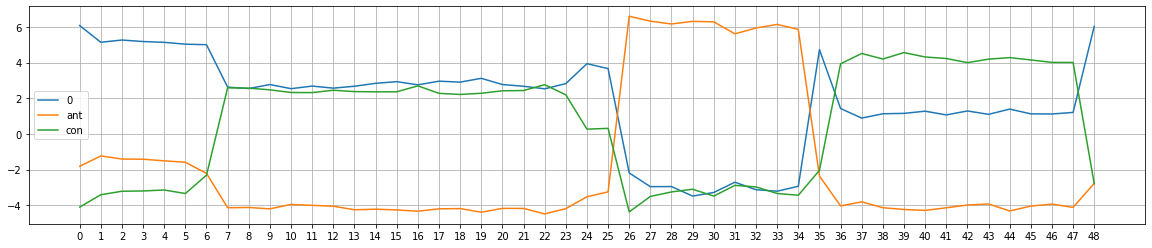

word ant (26, 34)
word con (7, 47)
ant (107, 161)
con (23, 230)
zero (89.03339660167694, [-1, -1, -1, -1])
one_open (92.08418154716492, [107, -1, -1, -1])
two_open (116.42918610572815, [-1, -1, 164, -1])
one_closed (171.09143269062042, [107, 161, -1, -1])
two_closed (125.24297976493835, [-1, -1, 164, 230])
one_closed_two_open (198.48722219467163, [107, 161, 164, -1])
two_closed_one_open (116.44492077827454, [231, -1, 164, 230])
one_closed_two_closed (207.30101585388184, [107, 161, 164, 230])
two_closed_one_closed (171.32400119304657, [107, 161, 85, 94])
alg_1 (107, 161)
alg_2 (164, 230)
the real ant (107,161)
the real con (23,100)
length:  232
--------------------------------------------
table 1466


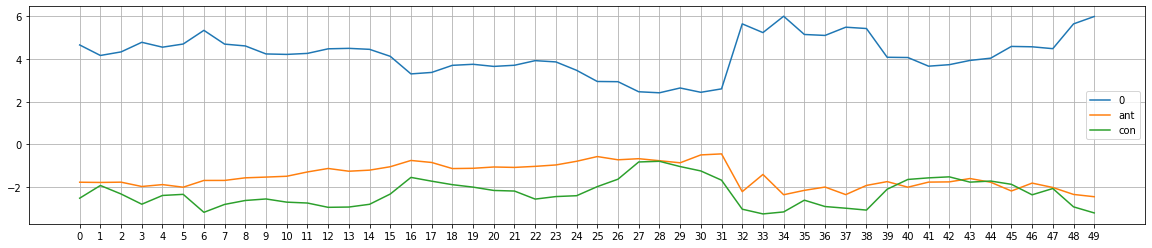

word ant (-1, -1)
word con (-1, -1)
ant (-1, -1)
con (-1, -1)
zero (210.51408576965332, [-1, -1, -1, -1])
one_open (202.0641369819641, [237, -1, -1, -1])
two_open (201.30392980575562, [-1, -1, 237, -1])
one_closed (207.57851338386536, [148, 151, -1, -1])
two_closed (207.3025280237198, [-1, -1, 145, 145])
one_closed_two_open (198.36835741996765, [148, 151, 237, -1])
two_closed_one_open (198.85257923603058, [237, -1, 145, 145])
one_closed_two_closed (204.16390186548233, [138, 144, 145, 145])
two_closed_one_closed (204.36695563793182, [148, 151, 145, 145])
alg_1 (-1, -1)
alg_2 (-1, -1)
the real ant (70,156)
the real con (-1,-1)
length:  238
--------------------------------------------
table 1575


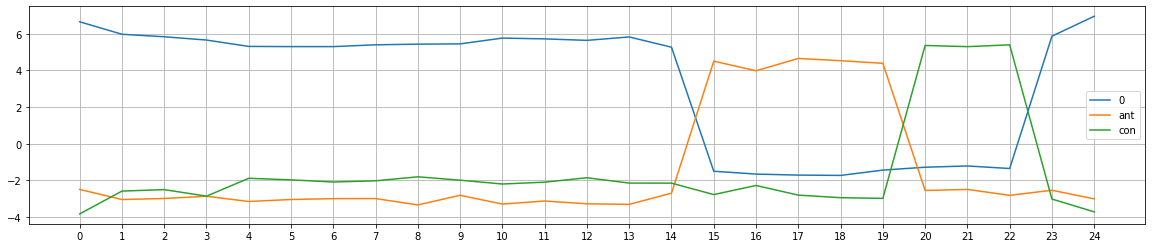

word ant (15, 19)
word con (14, 22)
ant (66, 93)
con (58, 107)
zero (85.38547325134277, [-1, -1, -1, -1])
one_open (93.09225654602051, [66, -1, -1, -1])
two_open (85.72677564620972, [-1, -1, 95, -1])
one_closed (115.46343517303467, [66, 93, -1, -1])
two_closed (105.27601051330566, [-1, -1, 95, 107])
one_closed_two_open (115.80473756790161, [66, 93, 95, -1])
two_closed_one_open (95.31676483154297, [109, -1, 95, 107])
one_closed_two_closed (135.35397243499756, [66, 93, 95, 107])
two_closed_one_closed (108.27325713634491, [66, 93, 17, 18])
alg_1 (66, 93)
alg_2 (95, 107)
the real ant (66,93)
the real con (95,107)
length:  110
--------------------------------------------
table 1621


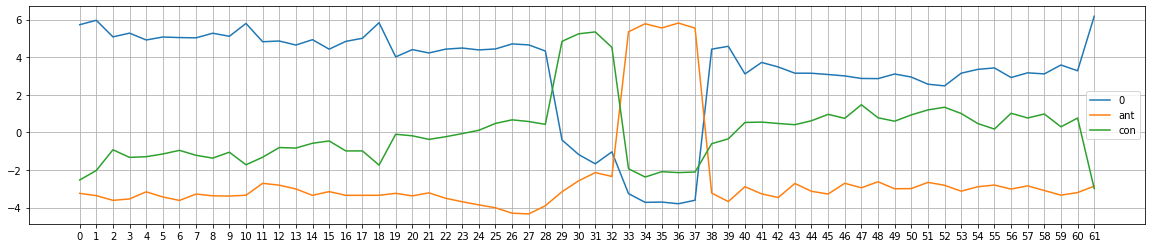

word ant (33, 37)
word con (24, 60)
ant (174, 196)
con (115, 297)
zero (199.98983326554298, [-1, -1, -1, -1])
one_open (190.95223513245583, [298, -1, -1, -1])
two_open (190.8218449652195, [-1, -1, 298, -1])
one_closed (246.1291209757328, [174, 196, -1, -1])
two_closed (231.67492997646332, [-1, -1, 149, 196])
one_closed_two_open (236.96113267540932, [174, 196, 298, -1])
two_closed_one_open (222.63733184337616, [298, -1, 149, 196])
one_closed_two_closed (244.99356558918953, [174, 196, 255, 257])
two_closed_one_closed (270.36795473098755, [174, 196, 149, 172])
alg_1 (174, 196)
alg_2 (149, 172)
the real ant (174,196)
the real con (149,172)
length:  299
--------------------------------------------
table 2213


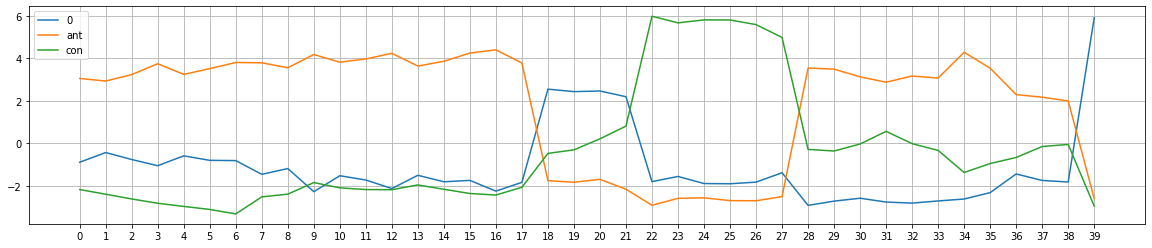

word ant (0, 38)
word con (20, 27)
ant (0, 198)
con (91, 136)
zero (-45.944852381944656, [-1, -1, -1, -1])
one_open (74.56864702701569, [0, -1, -1, -1])
two_open (12.154566083103418, [-1, -1, 103, -1])
one_closed (83.07663357257843, [0, 198, -1, -1])
two_closed (21.0121467448771, [-1, -1, 103, 198])
one_closed_two_open (103.87591833248734, [0, 81, 103, -1])
two_closed_one_open (69.34460008144379, [3, -1, 0, 1])
one_closed_two_closed (112.73349899426103, [0, 81, 103, 198])
two_closed_one_closed (77.85258662700653, [3, 198, 0, 1])
alg_1 (0, 81)
alg_2 (103, 198)
the real ant (0,81)
the real con (103,198)
length:  200
--------------------------------------------
table 2285


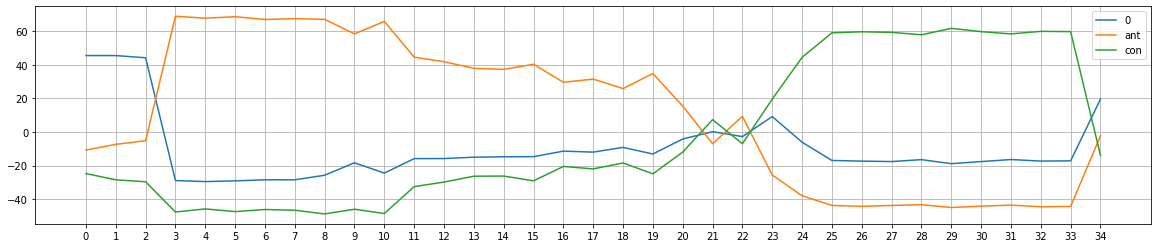

word ant (3, 22)
word con (21, 33)
ant (15, 152)
con (134, 213)
zero (-338.31412783265114, [-1, -1, -1, -1])
one_open (545.7041916847229, [15, -1, -1, -1])
two_open (382.59673500061035, [-1, -1, 134, -1])
one_closed (874.6929540634155, [15, 152, -1, -1])
two_closed (416.01928997039795, [-1, -1, 134, 213])
one_closed_two_open (1592.7093873023987, [15, 152, 154, -1])
two_closed_one_open (475.52659845352173, [15, -1, 0, 1])
one_closed_two_closed (1626.1319422721863, [15, 152, 154, 213])
two_closed_one_closed (804.5153608322144, [15, 152, 0, 1])
alg_1 (15, 152)
alg_2 (154, 213)
the real ant (15,128)
the real con (158,213)
length:  215
--------------------------------------------
table 2404


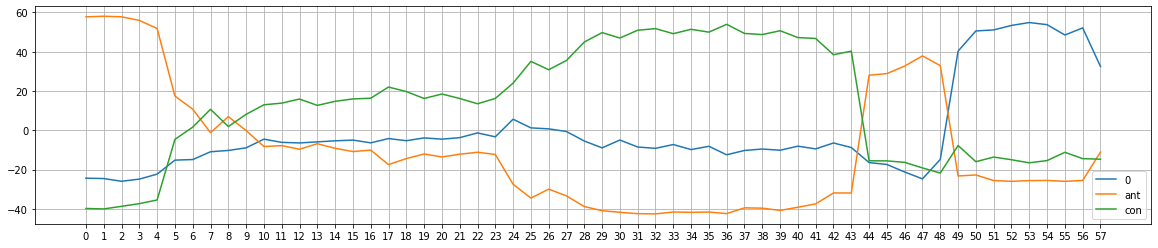

word ant (0, 8)
word con (7, 43)
ant (0, 40)
con (30, 211)
zero (-37.963003754615784, [-1, -1, -1, -1])
one_open (-81.5576320886612, [271, -1, -1, -1])
two_open (801.6168892383575, [-1, -1, 19, -1])
one_closed (459.51213508844376, [0, 47, -1, -1])
two_closed (1370.453313112259, [-1, -1, 19, 232])
one_closed_two_open (1236.3107591867447, [0, 28, 30, -1])
two_closed_one_open (1326.8586847782135, [271, -1, 19, 232])
one_closed_two_closed (1805.147183060646, [0, 28, 30, 232])
two_closed_one_closed (1612.3064396381378, [213, 235, 19, 211])
alg_1 (0, 28)
alg_2 (30, 232)
the real ant (0,115)
the real con (-1,-1)
length:  272
--------------------------------------------
table 2436


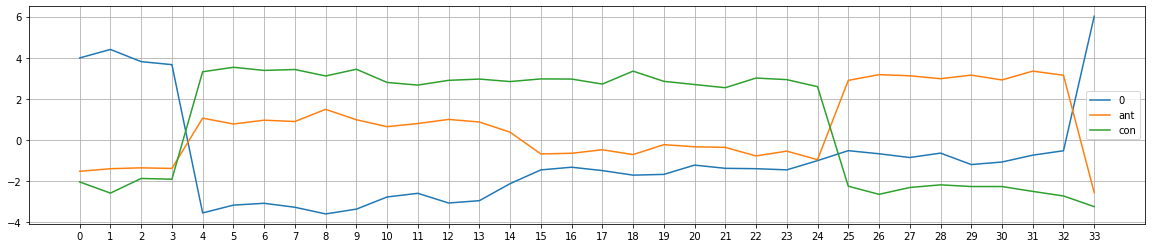

word ant (3, 32)
word con (4, 24)
ant (21, 206)
con (26, 154)
zero (-32.25853651762009, [-1, -1, -1, -1])
one_open (42.048503905534744, [26, -1, -1, -1])
two_open (56.35302114486694, [-1, -1, 26, -1])
one_closed (50.638746291399, [26, 206, -1, -1])
two_closed (78.572778403759, [-1, -1, 26, 154])
one_closed_two_open (54.094122767448425, [26, 30, 31, -1])
two_closed_one_open (100.9902868270874, [156, -1, 26, 154])
one_closed_two_closed (76.31388002634048, [26, 30, 31, 154])
two_closed_one_closed (109.58052921295166, [156, 206, 26, 154])
alg_1 (156, 206)
alg_2 (26, 154)
the real ant (156,206)
the real con (26,154)
length:  208
--------------------------------------------
table 2740


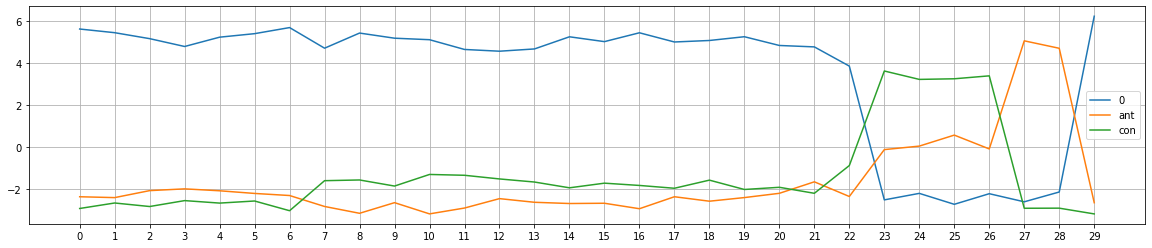

word ant (21, 28)
word con (23, 26)
ant (102, 145)
con (115, 134)
zero (108.23705649375916, [-1, -1, -1, -1])
one_open (124.00883254408836, [115, -1, -1, -1])
two_open (120.9565019607544, [-1, -1, 115, -1])
one_closed (132.92673787474632, [115, 145, -1, -1])
two_closed (131.49282050132751, [-1, -1, 115, 134])
one_closed_two_open (123.47219714522362, [115, 145, 146, -1])
two_closed_one_open (137.14845275878906, [136, -1, 115, 134])
one_closed_two_closed (127.73306928575039, [115, 118, 120, 134])
two_closed_one_closed (146.06635808944702, [136, 145, 115, 134])
alg_1 (136, 145)
alg_2 (115, 134)
the real ant (136,145)
the real con (115,134)
length:  147
--------------------------------------------
table 2746


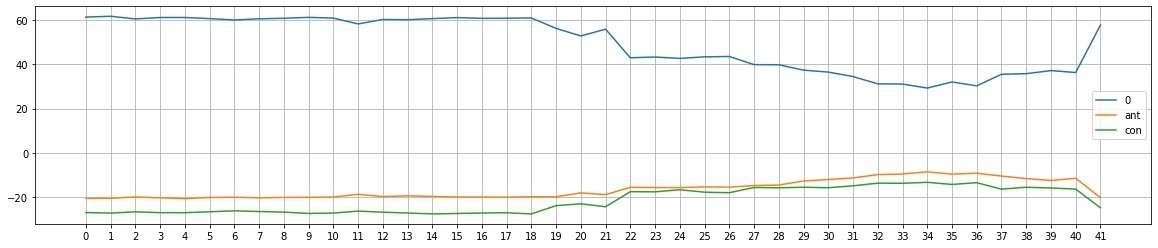

word ant (-1, -1)
word con (-1, -1)
ant (-1, -1)
con (-1, -1)
zero (2078.3994674682617, [-1, -1, -1, -1])
one_open (2000.3122787475586, [223, -1, -1, -1])
two_open (1995.759391784668, [-1, -1, 223, -1])
one_closed (2040.5271682739258, [185, 188, -1, -1])
two_closed (2035.7863187789917, [-1, -1, 185, 188])
one_closed_two_open (1957.887092590332, [185, 188, 223, -1])
two_closed_one_open (1957.6991300582886, [223, -1, 185, 188])
one_closed_two_closed (1996.7468843460083, [185, 188, 195, 196])
two_closed_one_closed (1996.2763996124268, [195, 196, 185, 188])
alg_1 (-1, -1)
alg_2 (-1, -1)
the real ant (0,116)
the real con (-1,-1)
length:  224
--------------------------------------------
table 3070


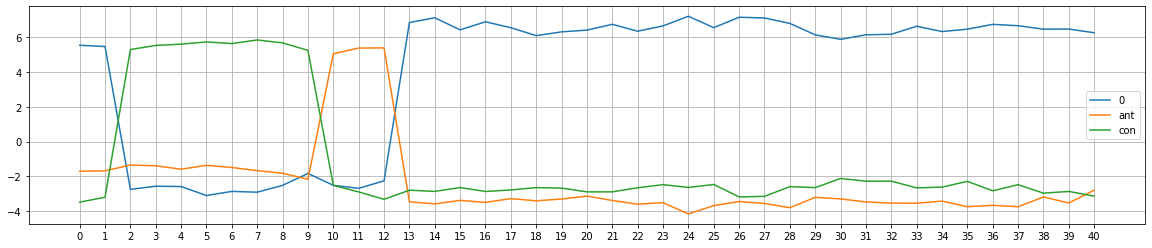

word ant (1, 12)
word con (2, 9)
ant (4, 60)
con (6, 47)
zero (166.10847532749176, [-1, -1, -1, -1])
one_open (157.05064165592194, [176, -1, -1, -1])
two_open (156.70487248897552, [-1, -1, 176, -1])
one_closed (197.69443488121033, [6, 60, -1, -1])
two_closed (231.85243821144104, [-1, -1, 6, 47])
one_closed_two_open (188.2908320426941, [6, 60, 176, -1])
two_closed_one_open (222.79460453987122, [176, -1, 6, 47])
one_closed_two_closed (225.2017079591751, [6, 6, 8, 47])
two_closed_one_closed (255.14856958389282, [49, 60, 6, 47])
alg_1 (49, 60)
alg_2 (6, 47)
the real ant (49,60)
the real con (6,47)
length:  177
--------------------------------------------
table 3104


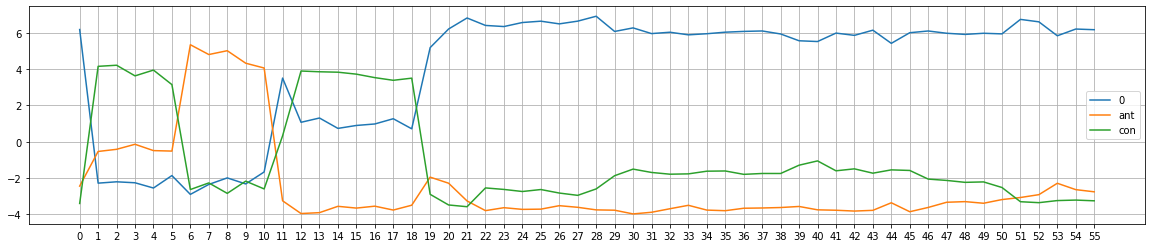

word ant (6, 10)
word con (1, 18)
ant (23, 41)
con (1, 77)
zero (220.82063794136047, [-1, -1, -1, -1])
one_open (211.89906644821167, [220, -1, -1, -1])
two_open (211.40374207496643, [-1, -1, 220, -1])
one_closed (264.6282520145178, [1, 41, -1, -1])
two_closed (265.3234498500824, [-1, -1, 1, 77])
one_closed_two_open (255.21135614812374, [1, 41, 220, -1])
two_closed_one_open (256.4018783569336, [220, -1, 1, 77])
one_closed_two_closed (283.364728435874, [1, 41, 47, 77])
two_closed_one_closed (285.79539036750793, [23, 41, 1, 21])
alg_1 (23, 41)
alg_2 (1, 21)
the real ant (23,41)
the real con (1,21)
length:  221
--------------------------------------------
table 3251


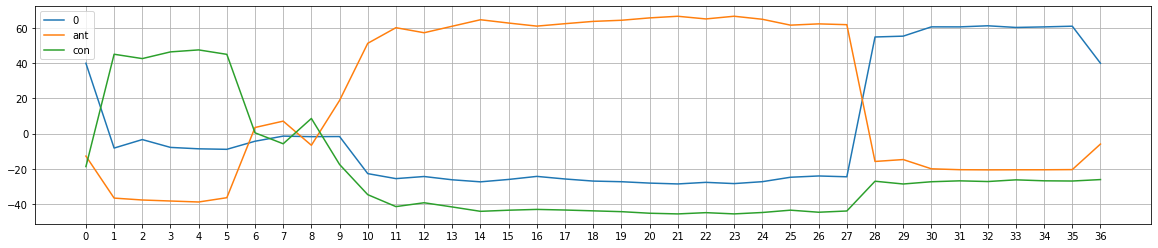

word ant (6, 27)
word con (1, 8)
ant (25, 131)
con (1, 35)
zero (39.02174413204193, [-1, -1, -1, -1])
one_open (992.7803416252136, [25, -1, -1, -1])
two_open (-27.17320215702057, [-1, -1, 157, -1])
one_closed (1667.6991739273071, [25, 131, -1, -1])
two_closed (313.94047090411186, [-1, -1, 1, 35])
one_closed_two_open (1601.5042276382446, [25, 131, 157, -1])
two_closed_one_open (1256.9161698818207, [25, -1, 1, 23])
one_closed_two_closed (1585.6267576217651, [25, 131, 132, 132])
two_closed_one_closed (1931.8350021839142, [25, 131, 1, 23])
alg_1 (25, 131)
alg_2 (1, 23)
the real ant (25,131)
the real con (1,23)
length:  158
--------------------------------------------
table 3367


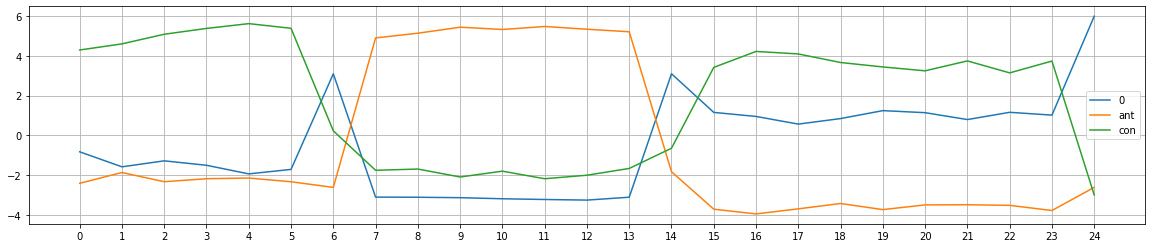

word ant (7, 13)
word con (0, 23)
ant (30, 50)
con (0, 95)
zero (-9.959956705570221, [-1, -1, -1, -1])
one_open (-6.213655531406403, [30, -1, -1, -1])
two_open (46.394493862986565, [-1, -1, 0, -1])
one_closed (48.97614711523056, [30, 50, -1, -1])
two_closed (55.37922506034374, [-1, -1, 0, 95])
one_closed_two_open (63.81651645898819, [30, 50, 53, -1])
two_closed_one_open (46.776114746928215, [96, -1, 0, 95])
one_closed_two_closed (72.80124765634537, [30, 50, 53, 95])
two_closed_one_closed (88.16556298732758, [30, 50, 0, 27])
alg_1 (30, 50)
alg_2 (0, 27)
the real ant (30,50)
the real con (0,95)
length:  97
--------------------------------------------
table 3412


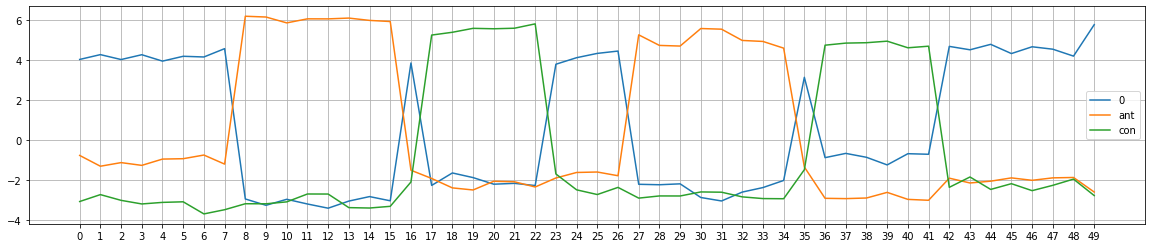

word ant (8, 34)
word con (17, 22)
ant (49, 172)
con (93, 121)
zero (33.40563666820526, [-1, -1, -1, -1])
one_open (65.79917216300964, [49, -1, -1, -1])
two_open (24.871976733207703, [-1, -1, 240, -1])
one_closed (136.32022154331207, [49, 172, -1, -1])
two_closed (79.28448247909546, [-1, -1, 93, 202])
one_closed_two_open (127.78656160831451, [49, 172, 240, -1])
two_closed_one_open (70.9276294708252, [240, -1, 93, 202])
one_closed_two_closed (170.02229630947113, [49, 172, 175, 202])
two_closed_one_closed (138.74419832229614, [133, 172, 93, 121])
alg_1 (49, 172)
alg_2 (175, 202)
the real ant (49,90)
the real con (93,121)
length:  241
--------------------------------------------
table 3448


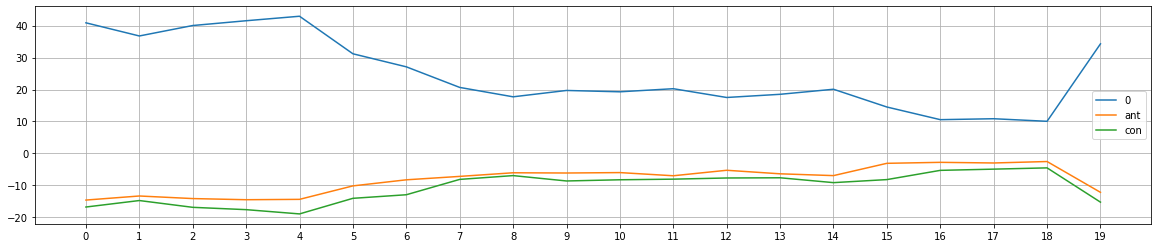

word ant (-1, -1)
word con (-1, -1)
ant (-1, -1)
con (-1, -1)
zero (494.2495365142822, [-1, -1, -1, -1])
one_open (447.8214750289917, [73, -1, -1, -1])
two_open (444.7500305175781, [-1, -1, 73, -1])
one_closed (481.6730246543884, [70, 72, -1, -1])
two_closed (479.68560457229614, [-1, -1, 70, 72])
one_closed_two_open (432.1735186576843, [70, 72, 73, -1])
two_closed_one_open (433.2575430870056, [73, -1, 70, 72])
one_closed_two_closed (466.3419291973114, [59, 64, 70, 72])
two_closed_one_closed (465.91007137298584, [70, 72, 66, 68])
alg_1 (-1, -1)
alg_2 (-1, -1)
the real ant (20,51)
the real con (-1,-1)
length:  74
--------------------------------------------
table 3512


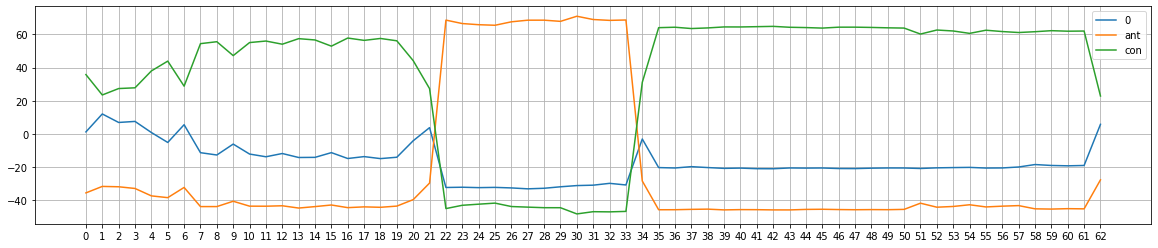

word ant (22, 33)
word con (0, 62)
ant (120, 174)
con (0, 319)
zero (-1058.2332637906075, [-1, -1, -1, -1])
one_open (-585.4184253811836, [120, -1, -1, -1])
two_open (2238.0076007843018, [-1, -1, 0, -1])
one_closed (138.79199522733688, [120, 174, -1, -1])
two_closed (2220.942903995514, [-1, -1, 0, 318])
one_closed_two_open (2441.705714404583, [120, 174, 175, -1])
two_closed_one_open (2187.4911575317383, [319, -1, 0, 318])
one_closed_two_closed (2424.641017615795, [120, 174, 175, 318])
two_closed_one_closed (2113.841139316559, [311, 318, 0, 309])
alg_1 (120, 174)
alg_2 (175, 319)
the real ant (120,318)
the real con (0,118)
length:  320


In [0]:
import matplotlib.pyplot as plt
index = 17
for index in indices:   # range(1500,1510) indices[26:35]
    X = [x[0] for x in logits_[index]]
    Y= [x[1] for x in logits_[index]]
    Z= [x[2] for x in logits_[index]]
    #X = [1,2,3,4,5]
    #Y = [0,1,-3,-4,3]
    #Z=[1,2,-1,-2,-5]
    print('--------------------------------------------')
    print('table {}'.format(index))
    fig = plt.figure(figsize=(20,4))
    ax = plt.subplot(111)
    ax.plot(X,label='0')
    ax.plot(Y,label='ant')
    ax.plot(Z,label='con')
    ax.set_xticks(range(0,len(X),5), minor=False)
    ax.set_xticks(range(0,len(X),1), minor=False)
    ax.legend()
    ax.grid(True)
    plt.show()
    print('word ant',ss_1[index])
    print('word con',ss_2[index])
    print('ant',pairs_1[index])
    print('con',pairs_2[index])
    print('zero',zero_list[index])
    print('one_open',one_open_list[index])
    print('two_open', two_open_list[index])
    print('one_closed', one_closed_list[index])
    print('two_closed', two_closed_list[index])
    print('one_closed_two_open',one_closed_two_open_list[index])
    print('two_closed_one_open',two_closed_one_open_list[index])
    print('one_closed_two_closed',one_closed_two_closed_list[index])
    print('two_closed_one_closed',two_closed_one_closed_list[index])
    print('alg_1',alg_pairs_1[index])
    print('alg_2',alg_pairs_2[index])
    print('the real ant ({},{})'.format(antecedent_startid[index],antecedent_endid[index]))
    print('the real con ({},{})'.format(consequent_startid[index],consequent_endid[index]))
    print('length: ', len(sentences[index]))

In [0]:
true_labels_tags = []
for q in true_labels:
    for batch in q:
        true_labels_tags.append([])
        for p_i in batch:
            if p_i != 3:
                true_labels_tags[-1].append(p_i)

for i in range(1300,1400):
    if pred_tags[i][:len(true_labels_tags[i])] != true_labels_tags[i]:
        print(pred_tags[i][:len(true_labels_tags[i])])
        print(true_labels_tags[i])
        print('----------------------')


[1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
----------------------
[0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
----------------------
[0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
----------------------
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [0]:
antecedent = []
consequent = []
for i,sent in enumerate(sentences):
    antecedent.append(sent[pred_antecedent_startid[i]:pred_antecedent_endid[i]+1])
    consequent.append(sent[pred_consequent_startid[i]:pred_consequent_endid[i]+1])

In [0]:
pred_antecedent_startid = [x[0] for x in alg_pairs_1]
pred_consequent_startid = [x[0] for x in alg_pairs_2]
pred_antecedent_endid = [x[1] for x in alg_pairs_1]
pred_consequent_endid = [x[1] for x in alg_pairs_2]

In [0]:
exact_match = 0
total = 0
for i in range(len(pred_antecedent_startid)):
    mark = False
    total += 1
    if pred_antecedent_startid[i] == antecedent_startid[i]:
        if pred_antecedent_endid[i] == antecedent_endid[i]:
            exact_match += 1
            mark = True
    if not mark:
        #print("-----------------\n------( {} )------".format(i))
        #print(pred_antecedent_startid[i], antecedent_startid[i])
        #print(pred_antecedent_endid[i], antecedent_endid[i])
        pass

print(exact_match/total)

0.8974936637566883


In [0]:
for i in range(len(pred_antecedent_startid)):
    mark = False
    total += 1
    if pred_antecedent_startid[i] == antecedent_startid[i]:
        if pred_antecedent_endid[i] == antecedent_endid[i]:
            exact_match += 1
            mark = True
    if not mark:
        print("-----------------\n------( {} )------".format(i))
        print(pred_antecedent_startid[i], antecedent_startid[i])
        print(pred_antecedent_endid[i], antecedent_endid[i])

print(exact_match, total)

-----------------
------( 16 )------
0 0
112 111
-----------------
------( 25 )------
59 69
129 129
-----------------
------( 38 )------
78 82
125 125
-----------------
------( 54 )------
1 0
110 110
-----------------
------( 76 )------
71 71
217 216
-----------------
------( 82 )------
75 75
280 279
-----------------
------( 87 )------
58 58
252 251
-----------------
------( 107 )------
35 117
171 170
-----------------
------( 113 )------
1 45
63 63
-----------------
------( 121 )------
85 85
187 208
-----------------
------( 145 )------
1 1
29 68
-----------------
------( 151 )------
0 0
88 66
-----------------
------( 154 )------
0 0
82 187
-----------------
------( 172 )------
0 0
218 217
-----------------
------( 174 )------
18 0
89 89
-----------------
------( 176 )------
4 4
151 113
-----------------
------( 179 )------
0 0
134 62
-----------------
------( 194 )------
63 63
205 204
-----------------
------( 198 )------
125 125
167 139
-----------------
------( 203 )------
37 0
1

In [0]:
frame = pd.DataFrame({'sentenceID': sentenceID, 
                               'antecedent_startid': pred_antecedent_startid, 
                               'antecedent_endid': pred_antecedent_endid, 
                               'consequent_startid': pred_consequent_startid,
                               'consequent_endid': pred_consequent_endid})
frame.to_csv('subtask2-mm.csv', encoding='utf-8', index=False)

In [0]:
data.columns

Index(['sentenceID', 'sentence', 'antecedent', 'consequent',
       'antecedent_startid', 'antecedent_endid', 'consequent_startid',
       'consequent_endid'],
      dtype='object')

##Prdiction on Real Test Set

In [0]:
data = pd.read_csv("subtask2_test.csv", encoding="utf-8").fillna(method="ffill")
data.tail(10)

sentences = list(data.sentence.values)
sentenceID = list(data.sentenceID.values)
N = len(sentences)
print(max([len(x.split(' ')) for x in sentences]))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_sentences = [tokenizer.tokenize(sent) for sent in sentences]
labels = [{token:0 for token in tokenized_sentence} for tokenized_sentence in tokenized_sentences]

96


88
1950


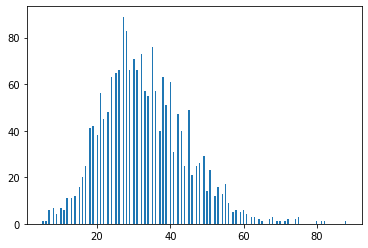

In [0]:
import matplotlib.pyplot as plt
A = [len(x) for x in labels]
plt.hist(A,bins=200)

print(max(A))
print(len(A))

In [0]:

labels = []
for i in range(N):
    S = slice(sentences[i], -1, -1)
    
    label = []
    for s in S:
        tokens = tokenizer.tokenize(s[1])
        label.extend([s[0] for token in tokens])
    label = [0] + label + [0]
    labels.append(label)


In [0]:

pad_token=0
input_ids = []
attention_masks = []
token_type_ids = []

for i,sentence in enumerate(sentences):
    inputs = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        max_length = max_length,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                )
    input_id, token_type_id = inputs["input_ids"], inputs["token_type_ids"]

    attention_mask = [1] * len(input_id)

    # Zero-pad up to the sequence length.
    padding_length = max_length - len(input_id)

    if len(labels[i]) != len(input_id):
        print(i)
        print(len(labels[i]), len(input_id))
        print(input_id)
        print(len(sentences[i]))
        print(sentences[i])

    label = labels[i]

    input_id = input_id + ([pad_token] * padding_length)
    attention_mask = attention_mask + ([0] * padding_length)
    token_type_id = token_type_id + ([0] * padding_length)

    labels[i] = label + ([0] * (padding_length))
    if i in [126]: 
        pass
    if i in [2490]:
        pass
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)  

In [0]:
for i, l in enumerate(labels):
    if len(l) != max_length:
        print(i)
        print(len(l))

In [0]:
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_token_type_ids = torch.tensor(token_type_ids)


# Set the batch size.  
batch_size = bs



# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_token_type_ids)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
model.eval()
predictions = []
true_labels = []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
logits = []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, _ = batch



    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
        f_labels = outputs[0]
        logits.extend(outputs[1])
    #logits = logits.detach().cpu().numpy()
    #predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    predictions.extend(f_labels)
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)



pred_tags = [p_i for p in predictions for p_i in p ]

In [0]:
logits_ = [[list(y) for y in list(x[0])[1:-1]] for x in logits]
[sum([x[1] for x in y]) for y in logits_]
A=[1,2,3]
#logits_[100]

In [0]:
import numpy as np
import time
pred_antecedent_startid = []
pred_antecedent_endid = []
pred_consequent_startid = []
pred_consequent_endid = []
pred_tags = [[p_i for p_i in p ] for p in predictions ]
logits_ = [[list(y) for y in list(x[0])[1:-1]] for x in logits]
#logits_exp = [[[np.exp(x) for x in y] for y in z] for z in logits_list]
#logits_softmax = [[[x/sum(y) for x in y] for y in z] for z in logits_list]
#logits_ = [[[x/sum(y) for x in y] for y in z] for z in logits_list]

zero_list = []
one_open_list = []
two_open_list = []
one_closed_list = []
two_closed_list = []
one_closed_two_open_list = []
two_closed_one_open_list = []
one_closed_two_closed_list = []
two_closed_one_closed_list = []

pairs_1 = []
pairs_2 = []
ss_1=[]
ss_2=[]
t= time.time()
alg_pairs_1 = []
alg_pairs_2 = []
for sample in range(len(sentences)): #len(sentences)
    if sample % 200 == 0:
        print('{} samples processed in {}'.format(sample, time.time()-t))
    
    
    loc = 0
    start_loc_label = {}
    start_loc_label_ = []
    end_loc_label = {}
    end_loc_label_ = []
    #print(sentences[sample])
    for rank, token in enumerate(tokenized_sentences[sample]):
        if token.startswith('##'):
            token = token.replace('##', '')
        for index in range(loc, len(sentences[sample])):
            if sentences[sample][index:index+len(token)].lower() == token:
                start_loc_label.update({index: pred_tags[sample][rank+1]})
                start_loc_label_.append((index, pred_tags[sample][rank+1]))
                end_loc_label.update({index+len(token)-1: 
                                        pred_tags[sample][rank+1]})
                end_loc_label_.append((index+len(token)-1,
                                        pred_tags[sample][rank+1]))
                loc = index+len(token)
                #sentences[sample][index:index+len(token)] = '~'*len(token)
                break

    #print(start_loc_label)
    #print(sentences[sample])
    #print(tokenized_sentences[sample])
    #print(start_loc_label)
    #print(end_loc_label)
    start_keys = sorted(list(start_loc_label.keys()))
    end_keys = sorted(list(end_loc_label.keys()))
    start_keys_ = [x[0] for x in start_loc_label_]
    end_keys_ = [x[0] for x in end_loc_label_]
    start_indices = list(range(len(start_keys)))
    end_indices = list(range(len(end_keys)))
    N = len(start_indices)
    #print(N)
    #print(len(logits_[sample]))


    '''
    XXX = tokenized_sentences[sample]
    for i in range(N):
        print(XXX[i],start_loc_label_[i],end_loc_label_[i])
        #print()
        #print()
    '''
    state = 0
    ant_starts = []
    for i in start_indices:
        if start_loc_label[start_keys[i]] == 1 and state != 1:
            ant_starts.append(start_keys[i])
        state = start_loc_label[start_keys[i]]


    state = 0
    ant_ends = []
    for i in end_indices[::-1]:
        if end_loc_label[end_keys[i]] == 1 and state != 1:
            ant_ends.append(end_keys[i])
        state = end_loc_label[end_keys[i]]

    state = 0
    con_starts = []
    for i in start_indices:
        if start_loc_label[start_keys[i]] == 2 and state != 2:
            con_starts.append(start_keys[i])
        state = start_loc_label[start_keys[i]]


    state = 0
    con_ends = []
    for i in end_indices[::-1]:
        if end_loc_label[end_keys[i]] == 2 and state != 2:
            con_ends.append(end_keys[i])
        state = end_loc_label[end_keys[i]]


    if len(ant_starts) > 0:
        pred_antecedent_startid.append(ant_starts[0])
    else:
        pred_antecedent_startid.append(-1)

    if len(ant_ends) > 0:
        pred_antecedent_endid.append(ant_ends[0])
    else:
        pred_antecedent_endid.append(-1)



    if len(con_starts) > 0:
        pred_consequent_startid.append(con_starts[0])
    else:
        pred_consequent_startid.append(-1)
    if len(con_ends) > 0:
        pred_consequent_endid.append(con_ends[0])
    else:
        pred_consequent_endid.append(-1)
    #antecedent.append(sentences[ant_starts[0]:ant_ends[-1]])


    # new attempt
    MAX_1 = 0
    MAX_2 = 0
    s_1= (-1,-1)
    s_2 = (-1,-1)
    pair_1 = (-1,-1)
    pair_2 = (-1,-1)

    max_fitness = 0
    inf = -10**20
    l = logits_[sample]
    #print(l)
    zero = {-1:(0,[-1,-1,-1,-1])}
    one_open = {-1:(inf,[-1,-1,-1,-1])}
    two_open = {-1:(inf,[-1,-1,-1,-1])}
    one_closed = {-1:(inf,[-1,-1,-1,-1])}
    two_closed = {-1:(inf,[-1,-1,-1,-1])}
    one_closed_two_open = {-1:(inf,[-1,-1,-1,-1])}
    two_closed_one_open = {-1:(inf,[-1,-1,-1,-1])}
    one_closed_two_closed = {-1:(inf,[-1,-1,-1,-1])}
    two_closed_one_closed = {-1:(inf,[-1,-1,-1,-1])}
    N = len(start_indices)

    for n in range(N):
        #print(n)
        ### zero
        zero[n] = (zero[n-1][0] + l[n][0],[-1,-1,-1,-1])
        #### one open #### 
        if zero[n-1][0] >= one_open[n-1][0]:
            one_open[n] = (zero[n-1][0]     + l[n][1], [start_keys_[n],-1,-1,-1])
        else:
            one_open[n] = (one_open[n-1][0] + l[n][1], one_open[n-1][1])

        ### two open #### 
        if zero[n-1][0] >= two_open[n-1][0]:
            two_open[n] = (zero[n-1][0]    + l[n][2], [-1,-1,start_keys_[n],-1])
        else:
            two_open[n] = (two_open[n-1][0] + l[n][2], two_open[n-1][1])

        ### one closed #### 
        if one_open[n-1][0] > one_closed[n-1][0]:
            one_closed[n] = (one_open[n-1][0]     + l[n][0], [one_open[n-1][1][0],end_keys_[n-1],-1,-1])
        else:
            one_closed[n] = (one_closed[n-1][0] + l[n][0], one_closed[n-1][1])

        ### two closed #### 
        if two_open[n-1][0] > two_closed[n-1][0]:
            two_closed[n] = (two_open[n-1][0]     + l[n][0], [-1,-1,two_open[n-1][1][2],end_keys_[n-1]])
        else:
            two_closed[n] = (two_closed[n-1][0] + l[n][0], two_closed[n-1][1])

        ### one closed two open #### 
        s0 = one_open[n-1][0]
        s1 = one_closed[n-1][0]
        s2 = one_closed_two_open[n-1][0]
        if s0 >= max(s1,s2) :
            one_closed_two_open[n] = (one_open[n-1][0]     + l[n][2], 
                                      [one_open[n-1][1][0],end_keys_[n-1],start_keys_[n],-1])
        elif s1 >= max(s0,s2):
            one_closed_two_open[n] = (one_closed[n-1][0]   + l[n][2], 
                                      [one_closed[n-1][1][0],one_closed[n-1][1][1],start_keys_[n],-1])
        else:
            one_closed_two_open[n] = (one_closed_two_open[n-1][0] + l[n][2], one_closed_two_open[n-1][1])

        ### two closed one open ##################
        s0 = two_open[n-1][0]
        s1 = two_closed[n-1][0]
        s2 = two_closed_one_open[n-1][0]
        if s0 >= max(s1,s2) :
            two_closed_one_open[n] = (two_open[n-1][0]     + l[n][1], 
                                      [start_keys_[n], -1, two_open[n-1][1][2], end_keys_[n-1]])
        elif s1 >= max(s0,s2):
            two_closed_one_open[n] = (two_closed[n-1][0]     + l[n][1], 
                                      [start_keys_[n],-1,two_closed[n-1][1][2],two_closed[n-1][1][3] ])
        else:
            two_closed_one_open[n] = (two_closed_one_open[n-1][0] + l[n][1], two_closed_one_open[n-1][1])


        ### one closed two closed #######################
        if one_closed_two_open[n-1][0] > one_closed_two_closed[n-1][0]:
            one_closed_two_closed[n] = (one_closed_two_open[n-1][0]     + l[n][0], 
                                        [one_closed_two_open[n-1][1][0],one_closed_two_open[n-1][1][1],
                                         one_closed_two_open[n-1][1][2],end_keys_[n-1]])
        else:
            one_closed_two_closed[n] = (one_closed_two_closed[n-1][0] + l[n][0], one_closed_two_closed[n-1][1])

        ### two closed one closed #### 
        if two_closed_one_open[n-1][0] > two_closed_one_closed[n-1][0]:
            two_closed_one_closed[n] = (two_closed_one_open[n-1][0]     + l[n][0], 
                                        [two_closed_one_open[n-1][1][0],end_keys_[n-1],
                                         two_closed_one_open[n-1][1][2],two_closed_one_open[n-1][1][3] ])
        else:
            two_closed_one_closed[n] = (two_closed_one_closed[n-1][0] + l[n][0], two_closed_one_closed[n-1][1])


    zero_list.append(zero[N-1])
    one_open_list.append(one_open[N-1])
    two_open_list.append(two_open[N-1])
    one_closed_list.append(one_closed[N-1])
    two_closed_list.append(two_closed[N-1])
    one_closed_two_open_list.append(one_closed_two_open[N-1])
    two_closed_one_open_list.append(two_closed_one_open[N-1])
    one_closed_two_closed_list.append(one_closed_two_closed[N-1])
    two_closed_one_closed_list.append(two_closed_one_closed[N-1])

    compare = [zero[N-1], one_open[N-1], two_open[N-1], one_closed[N-1], two_closed[N-1],
               one_closed_two_open[N-1], two_closed_one_open[N-1], one_closed_two_closed[N-1],
               two_closed_one_closed[N-1]]
    
    max_index = compare.index(max(compare))
    if max_index == 0: # zero
        x1,x2, y1,y2 = zero[N-1][1]

    if max_index == 1: # one_open
        x1,x2, y1,y2 = one_open[N-1][1]
        x2 = end_keys_[N-1]

    if max_index == 2: # two_open
        x1,x2, y1,y2 = two_open[N-1][1]
        y2 = end_keys_[N-1]

    if max_index == 3: # one_closed
        x1,x2, y1,y2 = one_closed[N-1][1]

    if max_index == 4: # two_closed
        x1,x2, y1,y2 = two_closed[N-1][1]

    if max_index == 5: # one_closed_two_open
        x1,x2, y1,y2 = one_closed_two_open[N-1][1]
        y2 = end_keys_[N-1]

    if max_index == 6: # two_closed_one_open
        x1,x2, y1,y2 = two_closed_one_open[N-1][1]
        x2 = end_keys_[N-1]

    if max_index == 7: # one_closed
        x1,x2, y1,y2 = one_closed_two_closed[N-1][1]

    if max_index == 8: # two_closed
        x1,x2, y1,y2 = two_closed_one_closed[N-1][1]


    alg_pairs_1.append((x1,x2))
    alg_pairs_2.append((y1,y2))


    MAX_1 = 0
    MAX_2 = 0
    s_1= (-1,-1)
    s_2 = (-1,-1)
    pair_1 = (-1,-1)
    pair_2 = (-1,-1)
    for i in range(N):
        for j in range(i-2):
            SUM_1 = sum([l[k][1] for k in range(j,i+1)])  #-max(l[k][0],l[k][2])
            if SUM_1>MAX_1:
                if l[i][1]>l[i][2] and l[j][1]>l[j][2]:
                    MAX_1 = SUM_1
                    pair_1 = (start_keys_[j],end_keys_[i])
                    s_1 = (j,i)
            SUM_2 = sum([l[k][2] for k in range(j,i+1)]) #-max(l[k][0],l[k][1])
            if SUM_2>MAX_2:
                if l[i][2]>l[i][1] and l[j][2]>l[j][1]:
                    MAX_2 = SUM_2
                    pair_2 = (start_keys_[j],end_keys_[i])
                    s_2 = (j,i)

    for i in range(N):
        for j in range(i-2):
            SUM_1 = sum([l[k][1] for k in range(j,i+1)])  #-max(l[k][0],l[k][2])
            if SUM_1>MAX_1:
                if l[i][1]>l[i][2] and l[j][1]>l[j][2]:
                    MAX_1 = SUM_1
                    pair_1 = (start_keys_[j],end_keys_[i])
                    s_1 = (j,i)
            SUM_2 = sum([l[k][2] for k in range(j,i+1)]) #-max(l[k][0],l[k][1])
            if SUM_2>MAX_2:
                if l[i][2]>l[i][1] and l[j][2]>l[j][1]:
                    MAX_2 = SUM_2
                    pair_2 = (start_keys_[j],end_keys_[i])
                    s_2 = (j,i)

    pairs_1.append(pair_1)
    pairs_2.append(pair_2)
    ss_1.append(s_1)
    ss_2.append(s_2)



print(pred_antecedent_startid)
print(pred_antecedent_endid)

0 samples processed in 0.0025382041931152344
200 samples processed in 6.096125364303589
400 samples processed in 11.472154378890991
600 samples processed in 17.04289984703064
800 samples processed in 23.17492389678955
1000 samples processed in 29.114190101623535
1200 samples processed in 34.206273555755615
1400 samples processed in 40.06376671791077
1600 samples processed in 45.574891567230225
1800 samples processed in 50.714457273483276
[24, 0, 151, 0, 1, 0, 49, 0, 42, 1, 0, 11, 0, 135, 21, 49, 74, 9, 170, 80, 10, 55, 0, 63, 86, 0, 0, 11, 57, 0, 134, 0, 99, 116, 2, 87, 1, 9, 180, 60, 0, 52, 0, 95, 11, 31, 1, 0, 34, 80, 1, 1, 133, 0, 43, 56, 42, 101, 16, 205, -1, 16, 0, 45, 4, 183, 53, 0, 128, 0, 136, 78, 0, 132, 51, 204, 71, 0, 182, 0, 0, 176, 249, 86, 0, 0, 141, 0, 28, 209, 0, 0, 0, 1, 0, 4, 1, 22, 0, 117, 126, 94, 14, 172, 62, 0, 88, 1, 60, 27, 118, 32, 0, 116, 4, 0, 1, 0, 97, 103, 56, 101, 4, 66, 371, 95, 39, 232, 42, 27, 0, 153, 0, 184, 0, 1, 47, 27, 86, 38, 0, 0, 0, 0, 0, 35, 130

In [0]:
antecedent = []
consequent = []
for i,sent in enumerate(sentences):
    antecedent.append(sent[pred_antecedent_startid[i]:pred_antecedent_endid[i]+1])
    consequent.append(sent[pred_consequent_startid[i]:pred_consequent_endid[i]+1])
pred_antecedent_startid_ = [x[0] for x in pairs_1]
pred_consequent_startid_ = [x[0] for x in pairs_2]
pred_antecedent_endid_ = [x[1] for x in pairs_1]
pred_consequent_endid_ = [x[1] for x in pairs_2]

In [0]:
pred_antecedent_startid_ = [x[0] for x in alg_pairs_1]
pred_consequent_startid_ = [x[0] for x in alg_pairs_2]
pred_antecedent_endid_ = [x[1] for x in alg_pairs_1]
pred_consequent_endid_ = [x[1] for x in alg_pairs_2]

In [0]:
print(pred_antecedent_startid)
print(pred_antecedent_endid)
print(pred_antecedent_startid_)
print(pred_antecedent_endid_)
for i in range(0,1000):
    print('{}*****************'.format(i))
    if (pred_antecedent_startid[i],pred_antecedent_endid[i]) != (pred_antecedent_startid_[i],pred_antecedent_endid_[i]):
            
        print('start---')
        print(pred_antecedent_startid[i],pred_antecedent_endid[i])
        print(pred_antecedent_startid_[i],pred_antecedent_endid_[i])
    if (pred_consequent_startid[i],pred_consequent_endid[i]) != (pred_consequent_startid_[i],pred_consequent_endid_[i]):
        print('end---')
        print(pred_consequent_startid[i],pred_consequent_endid[i])
        print(pred_consequent_startid_[i],pred_consequent_endid_[i])

[24, 0, 151, 0, 1, 0, 49, 0, 42, 1, 0, 11, 0, 135, 21, 49, 74, 9, 170, 80, 10, 55, 0, 63, 86, 0, 0, 11, 57, 0, 134, 0, 99, 116, 2, 87, 1, 9, 180, 60, 0, 52, 0, 95, 11, 31, 1, 0, 34, 80, 1, 1, 133, 0, 43, 56, 42, 101, 16, 205, -1, 16, 0, 45, 4, 183, 53, 0, 128, 0, 136, 78, 0, 132, 51, 204, 71, 0, 182, 0, 0, 176, 249, 86, 0, 0, 141, 0, 28, 209, 0, 0, 0, 1, 0, 4, 1, 22, 0, 117, 126, 94, 14, 172, 62, 0, 88, 1, 60, 27, 118, 32, 0, 116, 4, 0, 1, 0, 97, 103, 56, 101, 4, 66, 371, 95, 39, 232, 42, 27, 0, 153, 0, 184, 0, 1, 47, 27, 86, 38, 0, 0, 0, 0, 0, 35, 130, 1, 1, 38, 133, 26, 17, 138, 72, 36, 0, 1, 105, 128, 46, 0, 0, 1, 124, 166, 0, 0, 158, 0, 12, 42, 16, 96, 1, 1, 38, 338, 30, 165, 0, 0, 42, 1, 125, 158, 181, 13, 93, 0, 4, 71, 30, 0, 0, 79, 0, 65, 190, 54, 10, 0, 182, 13, 0, 57, 62, 16, 94, 1, 161, 0, 1, 185, 39, 104, 1, 128, 0, 1, 167, -1, 78, 0, 0, 104, 324, 0, 15, 1, 0, 21, 0, 0, 1, 1, 1, 0, 63, 0, 22, 0, 0, 1, 40, 0, 95, 0, 30, 122, 0, 0, 0, 0, 0, 101, 9, 0, 82, 0, 24, 1, 189, 0, 77,

In [0]:
counter = 0
indices = []
def detect_intersect(X,Y):
    x1, x2 = X
    y1, y2 = Y
    if x1 <=y1<=x2 or y1<=x1<=y2:
        print('---{}----'.format(i))
        print(pairs_1[i])
        print(pairs_2[i])
        return 1,i
    return 0,-1

for i in range(len(pairs_1)):
    add , index = detect_intersect(pairs_1[i],pairs_2[i])
    counter += add
    if add == 1:
        indices.append(index)
print(counter)
print(indices)

---60----
(-1, -1)
(-1, -1)
---97----
(20, 69)
(59, 101)
---111----
(32, 223)
(142, 181)
---179----
(165, 206)
(88, 233)
---327----
(93, 221)
(109, 220)
---642----
(60, 166)
(0, 78)
---663----
(1, 143)
(97, 250)
---712----
(-1, -1)
(-1, -1)
---750----
(0, 80)
(21, 193)
---932----
(387, 417)
(86, 530)
---942----
(0, 277)
(221, 276)
---1030----
(28, 50)
(0, 126)
---1333----
(86, 134)
(92, 123)
---1393----
(0, 134)
(82, 153)
---1418----
(65, 240)
(140, 201)
---1659----
(109, 129)
(47, 182)
---1727----
(-1, -1)
(-1, -1)
---1788----
(17, 127)
(82, 103)
---1850----
(85, 353)
(121, 175)
19
[60, 97, 111, 179, 327, 642, 663, 712, 750, 932, 942, 1030, 1333, 1393, 1418, 1659, 1727, 1788, 1850]


table 60


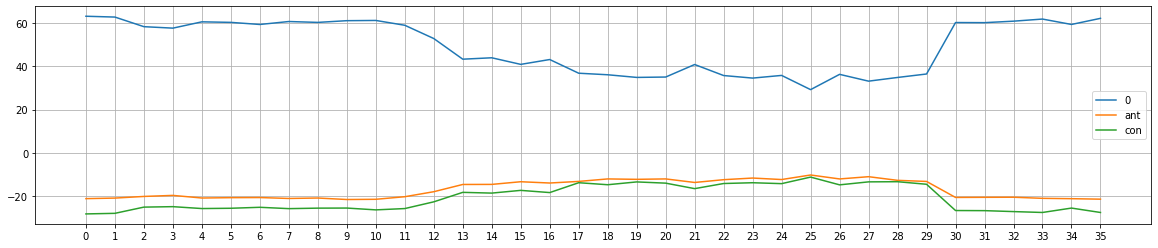

ant (-1, -1)
con (-1, -1)
table 97


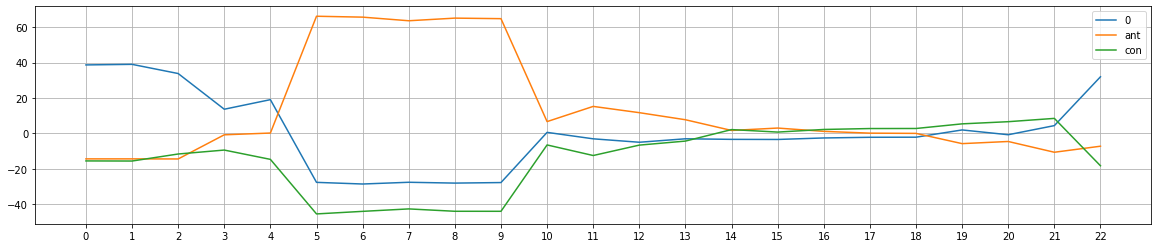

ant (4, 15)
con (14, 21)
table 111


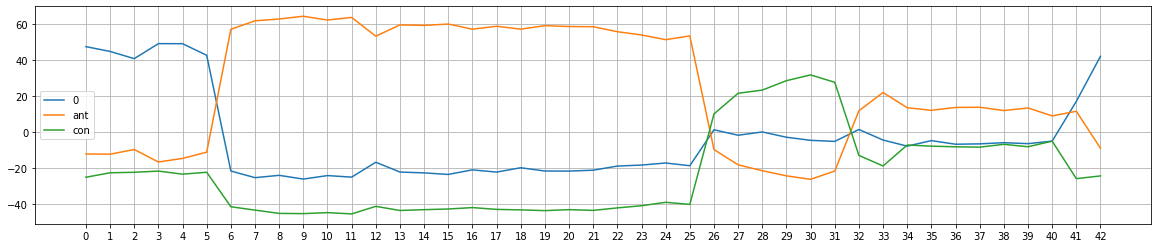

ant (6, 41)
con (26, 31)
table 179


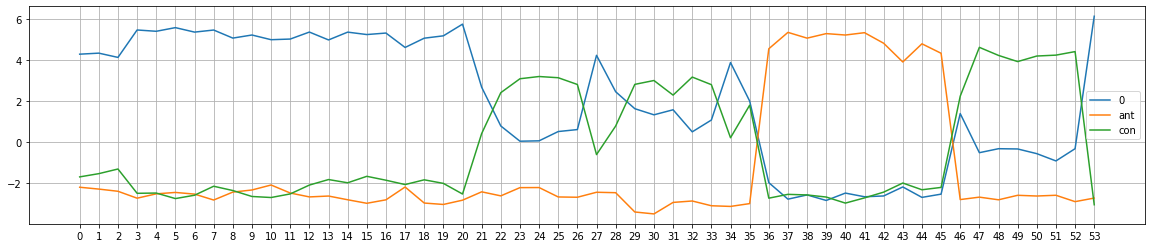

ant (36, 45)
con (21, 52)
table 327


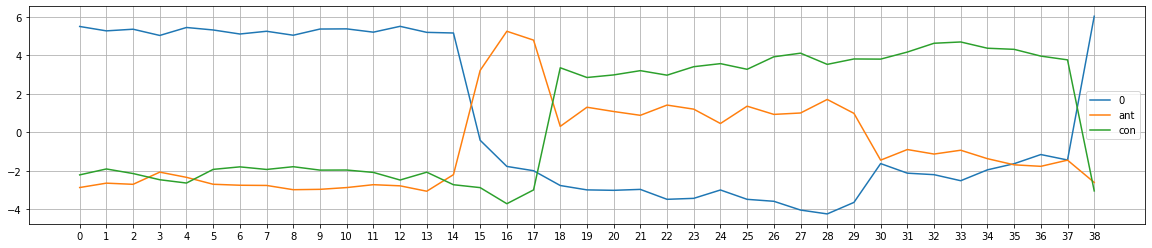

ant (15, 38)
con (18, 37)
table 642


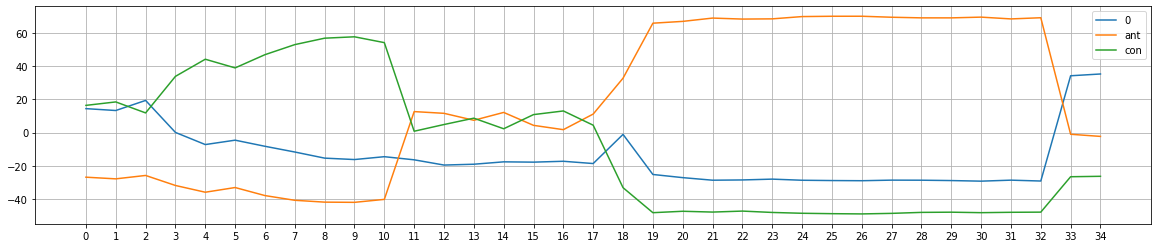

ant (11, 32)
con (0, 16)
table 663


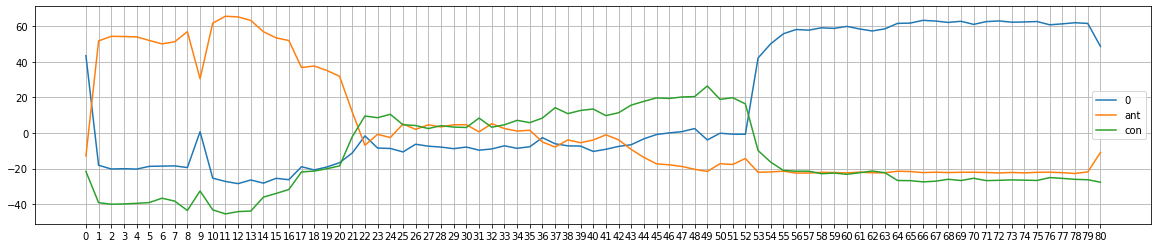

ant (1, 32)
con (22, 52)
table 712


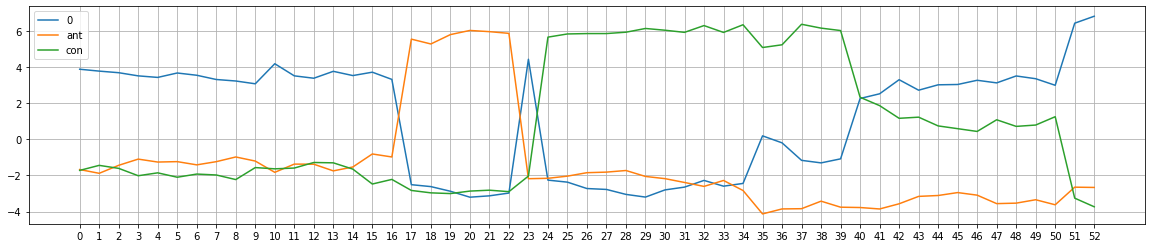

ant (-1, -1)
con (-1, -1)
table 750


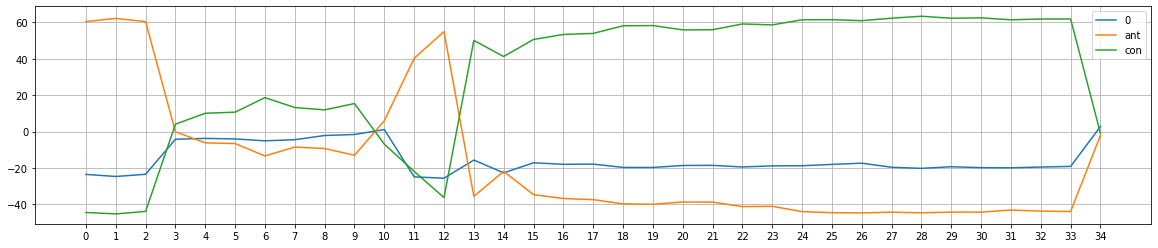

ant (0, 12)
con (3, 33)
table 932


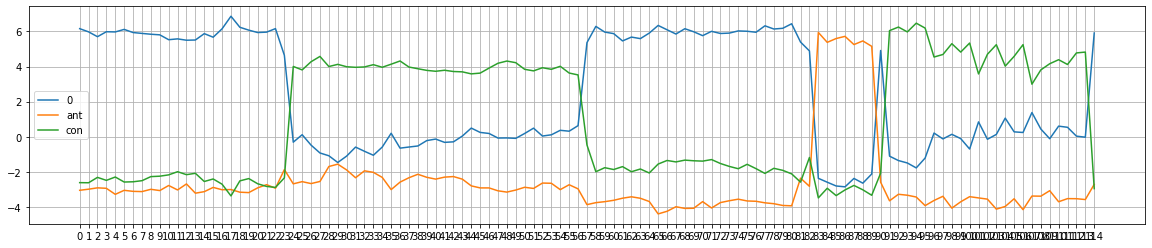

ant (83, 89)
con (24, 113)


In [0]:
import matplotlib.pyplot as plt
index = 17
for index in indices[:10]:   #range(46,1220)
    X = [x[0] for x in logits_[index]]
    Y= [x[1] for x in logits_[index]]
    Z= [x[2] for x in logits_[index]]
    #X = [1,2,3,4,5]
    #Y = [0,1,-3,-4,3]
    #Z=[1,2,-1,-2,-5]
    print('table {}'.format(index))
    fig = plt.figure(figsize=(20,4))
    ax = plt.subplot(111)
    ax.plot(X,label='0')
    ax.plot(Y,label='ant')
    ax.plot(Z,label='con')
    ax.set_xticks(range(0,len(X),5), minor=False)
    ax.set_xticks(range(0,len(X),1), minor=False)
    ax.legend()
    ax.grid(True)
    plt.show()
    print('ant',ss_1[index])
    print('con',ss_2[index])

In [0]:
'''
frame = pd.DataFrame({'sentenceID': sentenceID, 
                               'antecedent_startid': pred_antecedent_startid, 
                               'antecedent_endid': pred_antecedent_endid, 
                               'consequent_startid': pred_consequent_startid,
                               'consequent_endid': pred_consequent_endid})
frame.to_csv('subtask2_.csv', encoding='utf-8', index=False)
'''
frame = pd.DataFrame({'sentenceID': sentenceID, 
                               'antecedent_startid': pred_antecedent_startid_, 
                               'antecedent_endid': pred_antecedent_endid_, 
                               'consequent_startid': pred_consequent_startid_,
                               'consequent_endid': pred_consequent_endid_})
frame.to_csv('subtask2_.csv', encoding='utf-8', index=False)